In [1]:
# Mount on drive
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/Colab Notebooks/UDL Mini Project

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks/UDL Mini Project


In [2]:
import math
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset, Dataset
from torchvision import datasets, transforms
from collections import defaultdict
import matplotlib.pyplot as plt
from tqdm import trange, tqdm
import heapq
import copy
import json
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

cpu


# 1. Preprocess Data

## 1.1 Load all the training and testing sets

In [3]:
def get_mnist_data(batch_train=64, batch_eval=256, root='./data'):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
    train = datasets.MNIST(root=root, train=True, download=True, transform=transform)
    test  = datasets.MNIST(root=root, train=False, download=True, transform=transform)

    train_loader_full = DataLoader(train, batch_size=batch_train, shuffle=True, num_workers=2, pin_memory=True)
    test_loader = DataLoader(test, batch_size=batch_eval, shuffle=False, num_workers=2, pin_memory=True)
    return train, train_loader_full, test, test_loader

train_dataset, train_loader_full, test_dataset, test_loader = get_mnist_data()

In [4]:
train_dataset[0][0].size()

torch.Size([1, 28, 28])

## 1.2 Take out subsets of training data

In [5]:
def set_seed(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

seed = 0
set_seed(seed)

In [6]:
def sample_balanced_seed(full_dataset: Dataset, n_per_class=2, num_classes=10, seed=0):
    set_seed(seed)
    indices_by_class = defaultdict(list)
    for idx, (_, label) in enumerate(full_dataset):
        indices_by_class[int(label)].append(idx)
    seed_indices = []
    for c in range(num_classes):
        choices = random.sample(indices_by_class[c], k=n_per_class)
        seed_indices.extend(choices)
    random.shuffle(seed_indices)
    return seed_indices 

In [7]:
# Take out 20 images, 2 per class
seed_idx = sample_balanced_seed(train_dataset, n_per_class=10, seed=seed)
labeled_subset = Subset(train_dataset, seed_idx)
train_loader_labeled = DataLoader(labeled_subset, batch_size=64, shuffle=True)
print(len(labeled_subset))

100


## 1.3 Create Dataset for Rotation Prediction SSL

In [8]:
class RotDataset(Dataset):
    """
    Given an underlying dataset that returns (x, y) (y ignored),
    produce 4 rotated versions per image with rotation label 0..3.
    x expected as tensor [1,H,W] already normalized.
    """
    def __init__(self, base_dataset, transform=None):
        self.base = base_dataset
        # rotation transforms: 0,90,180,270
        self.rots = [lambda x: x,
                     lambda x: torch.rot90(x, 1, dims=[-2,-1]),
                     lambda x: torch.rot90(x, 2, dims=[-2,-1]),
                     lambda x: torch.rot90(x, 3, dims=[-2,-1])]
        self.transform = transform

    def __len__(self):
        return len(self.base) * 4

    def __getitem__(self, idx):
        base_idx = idx // 4
        rot_idx = idx % 4
        x, _ = self.base[base_idx]
        x_rot = self.rots[rot_idx](x)
        if self.transform:
            x_rot = self.transform(x_rot)
        return x_rot, rot_idx

# 2. Model Definition


## 2.1 Bayesian CNN

In [9]:
class BayesianCNN(nn.Module):
    def __init__(self, in_channel=1, out_channel=10, p_conv=0.25, p_fc=0.5):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channel, 32, kernel_size=4, padding=0)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=4, padding=0)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout_conv = nn.Dropout2d(p_conv)
        self.fc1 = nn.Linear(32*11*11, 128)
        self.dropout_fc = nn.Dropout(p_fc)
        self.fc2 = nn.Linear(128, out_channel)
        #self._init_prior_weight()

    def _init_prior_weight(self):
        # use small gaussian prior N(0, 0.05)
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                m.weight.data.normal_(0, 0.05)
                if m.bias is not None:
                    m.bias.data.zero_()


    def forward(self, x):
        # x: [B, 1, 28, 28] MNIST dimension
        x = F.relu(self.conv1(x))   # x: [B, 32, 25, 25]
        x = F.relu(self.conv2(x))   # x: [B, 32, 22, 22]
        x = self.pool1(x)           # x: [B, 32, 11, 11]
        x = self.dropout_conv(x)   
        x = torch.flatten(x, 1)     # x: [B, 32*11*11]
        x = F.relu(self.fc1(x))
        x = self.dropout_fc(x)      # dropout on FC layers
        logits = self.fc2(x)
        return logits               # returning pre-softmax logits

## 2.2 Model SSL Pretraining

In [10]:
#@title Rotation Prediction Pretraining
def ssl_rotation_pretrain_cnn(base_dataset, model: BayesianCNN,
                              device='cpu', batch_size=256, epochs=30, lr=1e-3, weight_decay=0.0):

    model = copy.deepcopy(model)  # work on a copy to preserve original
    model.to(device)

    orig_fc2 = model.fc2
    model.fc2 = nn.Linear(model.fc2.in_features, 4).to(device)

    rot_ds = RotDataset(base_dataset)
    loader = DataLoader(rot_ds, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)

    opt = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    loss_fn = nn.CrossEntropyLoss()

    model.train()
    for ep in range(epochs):
        running = 0.0
        N = 0
        for x, r in loader:
            x = x.to(device)
            r = r.to(device)
            opt.zero_grad()
            logits = model(x)        
            loss = loss_fn(logits, r)
            loss.backward()
            opt.step()
            running += loss.item() * x.size(0)
            N += x.size(0)
        print(f"[SSL ep {ep+1}/{epochs}] rot_loss={(running/N):.4f}")

    prior_state = {}
    for name, param in model.named_parameters():
        prior_state[name] = param.detach().cpu().clone()

    model.fc2 = orig_fc2
    return prior_state

In [11]:
#@title Helper to initialise W_SSL into target BCNN
def inject_prior_mean_into_model(model: BayesianCNN, prior_state: dict, device='cpu'):
    
    prior_params = {}
    state = model.state_dict()  
    for name, val in prior_state.items():
        if name in state and state[name].shape == val.shape:
            state[name].copy_(val.to(state[name].device))
            prior_params[name] = val.to(device).clone()
        else:
            print(f"skip prior param {name} shape mismatch")
            pass
    model.load_state_dict(state)
    return prior_params


# 3. Training Loop

In [12]:
lr=1e-3
weight_decay=1e-4

model = BayesianCNN(out_channel=10, p_conv=0.25, p_fc=0.5).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
criterion = nn.CrossEntropyLoss()

In [13]:
#@title Anchor L2 penalty
def compute_anchor_penalty(model, prior_params, ell2, N_data, p_conv=0.25, p_fc=0.5, device='cpu'):

    penalty = torch.tensor(0.0, device=device)
    # mapping rule: param name contains 'conv' -> p_conv; contains 'fc' -> p_fc; else lambda=0
    for name, param in model.named_parameters():
        if name not in prior_params:
            continue
        prior = prior_params[name].to(device)
        if 'conv' in name:
            p_layer = p_conv
        elif 'fc' in name or 'head' in name:
            p_layer = p_fc
        else:
            p_layer = p_fc 
        retention = (1.0 - p_layer)
        lam = retention / (N_data * ell2)   # lambda per earlier mapping
        # add 0.5 * lambda * ||param - prior||^2
        diff = param - prior.to(param.device)
        penalty = penalty + 0.5 * lam * torch.sum(diff * diff)
    return penalty


In [14]:
def train_one_epoch_ssl_finetune(model, train_loader, optimizer, criterion,
                                 prior_params, ell2, N_data,
                                 p_conv=0.25, p_fc=0.5, device='cpu'):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        logits = model(x)                
        data_loss = criterion(logits, y)
        # compute anchor penalty
        anchor_pen = compute_anchor_penalty(model, prior_params, ell2, N_data, p_conv, p_fc, device=device)
        loss = data_loss + anchor_pen
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * x.size(0)
        preds = logits.argmax(dim=1)
        correct += (preds == y).sum().item()
        total += x.size(0)
    return running_loss / total, correct / total


In [15]:
#@title Pretrain model
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# 1) create base model and pretrain SSL rotation on whole unlabeled train set
base_model = BayesianCNN(in_channel=1, out_channel=10, p_conv=0.25, p_fc=0.5)
prior_state = ssl_rotation_pretrain_cnn(train_dataset, base_model, device=device,
                                        batch_size=256, epochs=5, lr=1e-3)

KeyboardInterrupt: 

In [ ]:
#@title Finetune model
# 2) instantiate a fresh BayesianCNN for finetuning and inject W_SSL
model = BayesianCNN(in_channel=1, out_channel=10, p_conv=0.25, p_fc=0.5).to(device)
prior_params = inject_prior_mean_into_model(model, prior_state, device=device)  # sets weights to W_SSL

# 3) Prepare labeled DataLoader (your labeled set)
# train_loader_labeled = DataLoader(labeled_subset, batch_size=128, shuffle=True, num_workers=2, pin_memory=True)
N_labeled = len(labeled_subset)
print("Labeled subset size:", N_labeled)

# 4) optimizer: set weight_decay=0 because anchored L2 implements prior
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=0.0)
criterion = nn.CrossEntropyLoss()

# 5) finetune with anchor penalty
ell2 = 10
epochs = 80

for epoch in range(epochs):
    loss, acc = train_one_epoch_ssl_finetune(model, train_loader_labeled, optimizer, criterion,
                                            prior_params, ell2, N_labeled, p_conv=0.25, p_fc=0.5,
                                            device=device)
    if (epoch+1) % 5 == 0 or epoch == 0:
        print(f"[Epoch {epoch+1}] loss={loss:.4f}, train_acc={acc:.3f}")

# 4. Model Evaluation


## 4.1 MC-Dropout Evaluation

In [16]:
@torch.no_grad()
def mc_predict(model, loader, T: int = 20, device='cpu'):
   
    model.train()  # keep dropout active; there is no BatchNorm so train() is safe

    all_probs = []
    for t in tqdm(range(T)):
        batch_probs = []
        for x, _ in loader:
            x = x.to(device)
            logits = model(x)                  # stochastic because dropout active
            p = F.softmax(logits, dim=1)
            batch_probs.append(p.cpu())
        batch_probs = torch.cat(batch_probs, dim=0)  # [N, C]
        all_probs.append(batch_probs.unsqueeze(0))   # [1, N, C]
    all_probs = torch.cat(all_probs, dim=0)         # [T, N, C]
    probs_mean = all_probs.mean(dim=0)              # [N, C]
    probs_std  = all_probs.std(dim=0)               # [N, C]
    return probs_mean, probs_std, all_probs        # move to CPU tensors

In [18]:
def evaluate_accuracy_from_probs(probs, labels):
    preds = probs.argmax(dim=1)   # take the maximum in predicted prob
    correct = (preds == labels).sum().item()
    return correct / len(labels)

In [ ]:
T_mc = 20

test_loader_for_mc = DataLoader(test_dataset, batch_size=256, shuffle=False)
probs_mean, probs_std, all_probs = mc_predict(model, test_loader_for_mc, T=T_mc, device=device)

# compute test accuracy using predictive mean
test_labels = torch.tensor([y for _, y in test_dataset])
test_acc_mc = evaluate_accuracy_from_probs(probs_mean, test_labels)
print(f"MC-dropout predictive mean accuracy (T={T_mc}): {test_acc_mc:.4f}")

## 4.2: Deterministic Evaluation (MC dropout is turned off)

In [17]:
@torch.no_grad()
def deterministic_predict(model: nn.Module, loader: DataLoader, device='cpu'):

    # Important!! set model.eval() (dropout disabled) to infer deterministically
    model.eval()
    probs = []
    with torch.no_grad():
        for x, _ in loader:
            x = x.to(device)
            logits = model(x)
            p = F.softmax(logits, dim=1) 
            probs.append(p.cpu())
    probs = torch.cat(probs, dim=0)
    return probs 


In [ ]:
test_labels = torch.tensor([y for _, y in test_dataset])
probs_det = deterministic_predict(model, test_loader, device=device)
test_acc_det = evaluate_accuracy_from_probs(probs_det, test_labels)
print(f"Deterministic prediction accuracy (dropout disabled): {test_acc_det:.4f}")

# 5. Active Learning

## 5.1 Acquisition Functions

First, define a helper function for entropy calculation.

In [29]:
# @title Entropy helper function
def compute_entropy(probs, eps=1e-12):
    probs_clamped = probs.clamp(min=eps)
    entropy = - (probs_clamped * probs_clamped.log()).sum(dim=-1)
    return entropy  # shape ... (scalar entropy per sample)

### 5.1.1 BALD (Mutual Information)

Approximated via MC sampling

In [19]:
@torch.no_grad()
def bald_acquisition(model: nn.Module, pool_dataset: Dataset, pool_indices: list,
                     T: int = 20, is_bayesian = True, batch_size: int = 256, device='cpu'):
    """
    Compute approximate BALD (mutual information) scores for the samples
    in pool_indices (indices from pool_dataset).

    Returns:
      - scores: numpy array of shape (len(pool_indices),) aligned with pool_indices order.

    Notes:
      - model.train() is invoked inside mc_predict to keep dropout active.
      - This function processes the pool in batches via a DataLoader over Subset(pool_dataset, pool_indices).
      - Entropy is computed as:
          BALD(x) = H[ p_mean(y|x) ] - E_t[ H[ p(y|x,omega_t) ] ]
    """
    # Create loader for the pool subset (preserve order by shuffle=False)
    pool_subset = Subset(pool_dataset, pool_indices)
    pool_loader = DataLoader(pool_subset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

    if is_bayesian:
        # Get MC predictive probs: all_probs: [T, N_pool, C]
        probs_mean, probs_std, all_probs = mc_predict(model, pool_loader, T=T, device=device)
    else:
        probs_mean = deterministic_predict(model, pool_loader, device=device)  # probs_mean: [N_pool, C]
        all_probs = probs_mean.unsqueeze(0) # all_probs: [1, N_pool, C]

    # compute H[p_mean(y|x)]
    H_mean = compute_entropy(probs_mean)  # [N_pool]

    # compute H_t = H[p(y|x,omega_t)] for each t, shape [T, N_pool]
    H_t = compute_entropy(all_probs)  # shape: [T, N_pool]
    H_expected = H_t.mean(dim=0)      # [N_pool]  (E_t H[p(y|x,omega_t)])

    # BALD score per sample
    bald_scores = (H_mean - H_expected).cpu().numpy()  # convert to numpy for easy top-k

    return bald_scores

## 5.2 Active Learning Loop

In [25]:
#@title Updated AL Loop

def active_learning_loop(model_ctor,            # callable returns fresh model instance (uninitialized)
                         train_dataset,         # full unlabeled+labelled dataset
                         test_dataset,
                         initial_labeled_idxs,
                         val_indices=None,
                         pool_subset=None,
                         candidate_pool_size=None,
                         n_acq_per_iter=10,
                         n_iterations=10,
                         epochs_per_round=50,
                         lr=1e-3,
                         weight_decay=0.0,     # set 0.0 if using anchor penalty to avoid double regularization
                         T_acq=20,
                         batch_train=64,
                         batch_pool=256,
                         reset_model=True,
                         device='cpu',
                         seed=0,
                         is_bayesian=True,
                         acquisition_fn=bald_acquisition,
                         acquisition_kwargs=None,
                         pretrained_model=None,  
                         prior_params=None,  
                         ell2=1.0,    
                         use_anchor=False,    
                         p_conv=0.25, p_fc=0.5):

    set_seed(seed)
    acquisition_kwargs = acquisition_kwargs or {}

    print("Training dataset size:", len(train_dataset))
    print("Test dataset size:", len(test_dataset))
    print("Initial Labelled set size:", len(initial_labeled_idxs))

    L = list(initial_labeled_idxs[:])
    all_indices = list(range(len(train_dataset)))
    U = [i for i in all_indices if i not in set(L)]
    if pool_subset is not None:
        U = [i for i in U if i in set(pool_subset)]

    model = model_ctor().to(device)
    if pretrained_model is not None and prior_params is not None:
        state = model.state_dict()
        for name, tensor in prior_params.items():
            if name in state and state[name].shape == tensor.shape:
                state[name].copy_(tensor.to(state[name].device))
        model.load_state_dict(state)

    init_state = copy.deepcopy(model.state_dict())

    history = {
        'labelled_set_sizes': [len(L)],
        'selected_indices_each_iter': [],
        'test_accs': [],
        'is_bayesian': is_bayesian,
    }

    # MAIN LOOP
    for it in range(n_iterations + 1):
        print(f"\n=== Acquisition iteration {it} | labelled size = {len(L)} | pool size = {len(U)} ===")

        # 1) DataLoader for labelled set
        labeled_subset = Subset(train_dataset, L)
        labeled_loader = DataLoader(labeled_subset, batch_size=batch_train, shuffle=True, num_workers=2, pin_memory=True)

        # 2) Initialize / reset a fresh model (so each round uses same init if reset_model True)
        model = model_ctor().to(device)
        if reset_model:
            model.load_state_dict(init_state)

        # 3) Optimizer & criterion
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
        criterion = nn.CrossEntropyLoss()

        # 4) TRAIN for epochs_per_round
        N_labeled = len(labeled_subset)
        for epoch in range(epochs_per_round):
            if use_anchor and prior_params is not None:
                # use the anchored finetune epoch that adds anchor penalty
                loss, acc = train_one_epoch_ssl_finetune(
                    model, labeled_loader, optimizer, criterion,
                    prior_params=prior_params, ell2=ell2, N_data=N_labeled,
                    p_conv=p_conv, p_fc=p_fc, device=device
                )
            else:
                # standard (dropout-on) training epoch (no prior anchor)
                loss, acc = train_one_epoch(model, labeled_loader, optimizer, criterion, device, epoch=epoch)
            if (epoch + 1) % 10 == 0 or epoch == 0:
                print(f"[Train epoch {epoch+1}/{epochs_per_round}] loss={loss:.4f}, train_acc={acc:.4f}")

        # 5) Evaluate on test set
        test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)
        test_labels = torch.tensor([y for _, y in test_dataset])
        if is_bayesian:
            probs_mean_test, probs_std_test, _ = mc_predict(model, test_loader, T=T_acq, device=device)
            test_acc = evaluate_accuracy_from_probs(probs_mean_test, test_labels)
            print(f"Test accuracy (MC predictive mean, T={T_acq}): {test_acc:.4f}")
        else:
            probs_det = deterministic_predict(model, test_loader, device=device)
            test_acc = evaluate_accuracy_from_probs(probs_det, test_labels)
            print(f"Test accuracy (deterministic): {test_acc:.4f}")

        history['test_accs'].append(test_acc)

        if it == n_iterations:
            break

        # 6) Candidate selection: subsample pool if candidate_pool_size specified
        print(f"Computing acquisition scores on pool (subsample size: {candidate_pool_size})")

        if candidate_pool_size is None or candidate_pool_size >= len(U):
            candidate_indices = list(U)
        else:
            candidate_indices = random.sample(U, k=min(candidate_pool_size, len(U)))

        # 7) Compute acquisition scores for candidates
        scores_on_candidates = acquisition_fn(model, train_dataset, pool_indices=candidate_indices,
                                              is_bayesian=True, **acquisition_kwargs)
        scores_on_candidates = np.asarray(scores_on_candidates)
        k = min(n_acq_per_iter, len(candidate_indices))
        topk_idx_in_candidates = np.argpartition(-scores_on_candidates, k-1)[:k]
        topk_sorted = topk_idx_in_candidates[np.argsort(-scores_on_candidates[topk_idx_in_candidates])]
        selected_indices = [candidate_indices[i] for i in topk_sorted.tolist()]

        # 8) Update sets
        for s in selected_indices:
            L.append(s)
            U.remove(s)

        history['labelled_set_sizes'].append(len(L))
        history['selected_indices_each_iter'].append(selected_indices)

        # checkpoint history
        with open('outputs/history_BCNN_intermediate.json', 'w') as f:
            json.dump(history, f)

    return history


## 5.3 Producing Results

In [61]:
#@title Config for CNN Extension
def make_model():
    return BayesianCNN(in_channel=1, out_channel=10, p_conv=0.25, p_fc=0.5)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
acq_functions = [bald_acquisition]
acq_names = ["BALD"]
output_dir = "outputs/cnn_ssl/"

# Datasets
train_dataset, train_loader_full, test_dataset, test_loader = get_mnist_data()
#train_dataset_small = Subset(train_dataset, range(1000))
#test_dataset_small = Subset(test_dataset, range(1000))
train_dataset_to_use = train_dataset
test_dataset_to_use = test_dataset

# Training Hyperparameters
ell2 = 10.0
n_iterations = 100  # Number of AL runs
T_acq = 20   # Number of MC samples for function evaluation and acquisition calculation
epochs_per_round = 100  # Number of finetuning epochs
candidate_pool_size = 2000  # Number of subsample for acquisition
seed = 9
set_seed(seed)

In [62]:
#@title Pretrain model
base_model = make_model()
prior_state = ssl_rotation_pretrain_cnn(train_dataset, base_model, device=device,
                                        batch_size=256, epochs=5, lr=1e-3)
fresh_model = BayesianCNN(in_channel=1, out_channel=10, p_conv=0.25, p_fc=0.5)
prior_params = inject_prior_mean_into_model(fresh_model, prior_state, device=device)
# prior_params is dict name->tensor (on device) and fresh_model weights now equal W_SSL

[SSL ep 1/5] rot_loss=0.1009
[SSL ep 2/5] rot_loss=0.0501
[SSL ep 3/5] rot_loss=0.0424
[SSL ep 4/5] rot_loss=0.0380
[SSL ep 5/5] rot_loss=0.0333
skip prior param fc2.weight shape mismatch
skip prior param fc2.bias shape mismatch


In [63]:
#@title Run all acquisition functions
for idx, acq_function in enumerate(acq_functions):
    acq_name = acq_names[idx]
    print(f"\n\n========== Running {acq_name} Seed {seed} ==========")

    initial_idxs = sample_balanced_seed(train_dataset_to_use, n_per_class=2, seed=seed)

    history = active_learning_loop(
        model_ctor=make_model,
        train_dataset=train_dataset,
        test_dataset=test_dataset,
        initial_labeled_idxs=initial_idxs,
        candidate_pool_size=candidate_pool_size,
        n_acq_per_iter=10,
        n_iterations=n_iterations,
        epochs_per_round=epochs_per_round,
        lr=1e-3,
        weight_decay=0.0,   # do not double-regularize
        T_acq=T_acq,
        batch_train=64,
        device=device,
        seed=seed,
        is_bayesian=False,
        batch_pool=256,
        reset_model=True,
        acquisition_fn=acq_function,
        acquisition_kwargs={'T':20, 'batch_size':256, 'device': device},
        pretrained_model=fresh_model,
        prior_params=prior_params,
        ell2=ell2,
        use_anchor=True,
        p_conv=0.25, p_fc=0.5
    )

    # Save history to a json file
    file_name = output_dir + f'history_CNN_SSL_{acq_name}_Run{seed}.json'
    with open(file_name, 'w') as f:
        json.dump(history, f)
    print(f"Results saved to {file_name}")



========== Running BALD Seed 9 ==========
Training dataset size: 60000
Test dataset size: 10000
Initial Labelled set size: 20

=== Acquisition iteration 0 | labelled size = 20 | pool size = 59980 ===
[Train epoch 1/100] loss=6.9724, train_acc=0.1000
[Train epoch 10/100] loss=1.5790, train_acc=0.4500
[Train epoch 20/100] loss=1.1562, train_acc=0.6000
[Train epoch 30/100] loss=0.6880, train_acc=0.7500
[Train epoch 40/100] loss=0.2778, train_acc=0.9500
[Train epoch 50/100] loss=0.0753, train_acc=1.0000
[Train epoch 60/100] loss=0.0801, train_acc=1.0000
[Train epoch 70/100] loss=0.0533, train_acc=1.0000
[Train epoch 80/100] loss=0.0993, train_acc=0.9500
[Train epoch 90/100] loss=0.0568, train_acc=1.0000
[Train epoch 100/100] loss=0.1078, train_acc=0.9500
Test accuracy (deterministic): 0.5292
Computing acquisition scores on pool (subsample size: 2000)


100%|██████████| 20/20 [00:06<00:00,  3.07it/s]


=== Acquisition iteration 1 | labelled size = 30 | pool size = 59970 ===


[Train epoch 1/100] loss=6.1560, train_acc=0.0333
[Train epoch 10/100] loss=1.8071, train_acc=0.3333
[Train epoch 20/100] loss=1.0917, train_acc=0.6333
[Train epoch 30/100] loss=0.5619, train_acc=0.9333
[Train epoch 40/100] loss=0.4146, train_acc=0.8667
[Train epoch 50/100] loss=0.0679, train_acc=1.0000
[Train epoch 60/100] loss=0.1336, train_acc=0.9667
[Train epoch 70/100] loss=0.0583, train_acc=1.0000
[Train epoch 80/100] loss=0.0620, train_acc=1.0000
[Train epoch 90/100] loss=0.0581, train_acc=1.0000
[Train epoch 100/100] loss=0.0649, train_acc=1.0000
Test accuracy (deterministic): 0.6069
Computing acquisition scores on pool (subsample size: 2000)


100%|██████████| 20/20 [00:06<00:00,  3.10it/s]


=== Acquisition iteration 2 | labelled size = 40 | pool size = 59960 ===


[Train epoch 1/100] loss=7.1251, train_acc=0.0750
[Train epoch 10/100] loss=2.0375, train_acc=0.3000
[Train epoch 20/100] loss=1.2291, train_acc=0.7500
[Train epoch 30/100] loss=0.5500, train_acc=0.8750
[Train epoch 40/100] loss=0.4481, train_acc=0.8250
[Train epoch 50/100] loss=0.1694, train_acc=0.9750
[Train epoch 60/100] loss=0.1435, train_acc=0.9750
[Train epoch 70/100] loss=0.1246, train_acc=1.0000
[Train epoch 80/100] loss=0.1143, train_acc=1.0000
[Train epoch 90/100] loss=0.0733, train_acc=1.0000
[Train epoch 100/100] loss=0.1564, train_acc=0.9500
Test accuracy (deterministic): 0.6831
Computing acquisition scores on pool (subsample size: 2000)


100%|██████████| 20/20 [00:06<00:00,  3.06it/s]


=== Acquisition iteration 3 | labelled size = 50 | pool size = 59950 ===


[Train epoch 1/100] loss=6.1379, train_acc=0.0600
[Train epoch 10/100] loss=1.6020, train_acc=0.4800
[Train epoch 20/100] loss=1.2356, train_acc=0.6400
[Train epoch 30/100] loss=0.5309, train_acc=0.8600
[Train epoch 40/100] loss=0.4696, train_acc=0.8600
[Train epoch 50/100] loss=0.2440, train_acc=0.9400
[Train epoch 60/100] loss=0.1317, train_acc=0.9800
[Train epoch 70/100] loss=0.1308, train_acc=0.9800
[Train epoch 80/100] loss=0.1098, train_acc=0.9800
[Train epoch 90/100] loss=0.1328, train_acc=0.9200
[Train epoch 100/100] loss=0.0664, train_acc=1.0000
Test accuracy (deterministic): 0.7316
Computing acquisition scores on pool (subsample size: 2000)


100%|██████████| 20/20 [00:06<00:00,  3.16it/s]


=== Acquisition iteration 4 | labelled size = 60 | pool size = 59940 ===


[Train epoch 1/100] loss=6.6652, train_acc=0.0833
[Train epoch 10/100] loss=1.8236, train_acc=0.3500
[Train epoch 20/100] loss=1.3539, train_acc=0.6167
[Train epoch 30/100] loss=0.8592, train_acc=0.7500
[Train epoch 40/100] loss=0.4605, train_acc=0.8833
[Train epoch 50/100] loss=0.2807, train_acc=0.9333
[Train epoch 60/100] loss=0.1856, train_acc=0.9500
[Train epoch 70/100] loss=0.0824, train_acc=1.0000
[Train epoch 80/100] loss=0.0942, train_acc=1.0000
[Train epoch 90/100] loss=0.0785, train_acc=0.9833
[Train epoch 100/100] loss=0.1773, train_acc=0.9333
Test accuracy (deterministic): 0.7909
Computing acquisition scores on pool (subsample size: 2000)


100%|██████████| 20/20 [00:06<00:00,  3.17it/s]


=== Acquisition iteration 5 | labelled size = 70 | pool size = 59930 ===


[Train epoch 1/100] loss=7.8888, train_acc=0.0429
[Train epoch 10/100] loss=1.8520, train_acc=0.2857
[Train epoch 20/100] loss=1.1201, train_acc=0.6714
[Train epoch 30/100] loss=0.6948, train_acc=0.8571
[Train epoch 40/100] loss=0.4012, train_acc=0.9000
[Train epoch 50/100] loss=0.1768, train_acc=0.9571
[Train epoch 60/100] loss=0.1338, train_acc=0.9714
[Train epoch 70/100] loss=0.1380, train_acc=0.9571
[Train epoch 80/100] loss=0.1710, train_acc=0.9286
[Train epoch 90/100] loss=0.1323, train_acc=0.9714
[Train epoch 100/100] loss=0.1081, train_acc=0.9857
Test accuracy (deterministic): 0.8047
Computing acquisition scores on pool (subsample size: 2000)


100%|██████████| 20/20 [00:06<00:00,  3.14it/s]


=== Acquisition iteration 6 | labelled size = 80 | pool size = 59920 ===


[Train epoch 1/100] loss=6.5990, train_acc=0.1250
[Train epoch 10/100] loss=1.7016, train_acc=0.4875
[Train epoch 20/100] loss=0.9230, train_acc=0.7250
[Train epoch 30/100] loss=0.4789, train_acc=0.8375
[Train epoch 40/100] loss=0.3382, train_acc=0.8750
[Train epoch 50/100] loss=0.1726, train_acc=0.9625
[Train epoch 60/100] loss=0.1044, train_acc=0.9875
[Train epoch 70/100] loss=0.0830, train_acc=1.0000
[Train epoch 80/100] loss=0.0917, train_acc=0.9875
[Train epoch 90/100] loss=0.0829, train_acc=0.9875
[Train epoch 100/100] loss=0.0601, train_acc=1.0000
Test accuracy (deterministic): 0.8411
Computing acquisition scores on pool (subsample size: 2000)


100%|██████████| 20/20 [00:06<00:00,  3.12it/s]


=== Acquisition iteration 7 | labelled size = 90 | pool size = 59910 ===


[Train epoch 1/100] loss=6.0486, train_acc=0.0556
[Train epoch 10/100] loss=1.7605, train_acc=0.3667
[Train epoch 20/100] loss=1.1010, train_acc=0.6667
[Train epoch 30/100] loss=0.5108, train_acc=0.8667
[Train epoch 40/100] loss=0.2592, train_acc=0.9444
[Train epoch 50/100] loss=0.1359, train_acc=0.9556
[Train epoch 60/100] loss=0.0879, train_acc=1.0000
[Train epoch 70/100] loss=0.1993, train_acc=0.9333
[Train epoch 80/100] loss=0.0944, train_acc=0.9667
[Train epoch 90/100] loss=0.1475, train_acc=0.9667
[Train epoch 100/100] loss=0.0844, train_acc=0.9778
Test accuracy (deterministic): 0.8512
Computing acquisition scores on pool (subsample size: 2000)


100%|██████████| 20/20 [00:06<00:00,  3.15it/s]


=== Acquisition iteration 8 | labelled size = 100 | pool size = 59900 ===


[Train epoch 1/100] loss=5.6693, train_acc=0.1100
[Train epoch 10/100] loss=1.7277, train_acc=0.3400
[Train epoch 20/100] loss=1.0185, train_acc=0.6800
[Train epoch 30/100] loss=0.3947, train_acc=0.8600
[Train epoch 40/100] loss=0.2856, train_acc=0.9300
[Train epoch 50/100] loss=0.1799, train_acc=0.9500
[Train epoch 60/100] loss=0.1362, train_acc=0.9600
[Train epoch 70/100] loss=0.1162, train_acc=0.9800
[Train epoch 80/100] loss=0.1164, train_acc=0.9900
[Train epoch 90/100] loss=0.0699, train_acc=0.9900
[Train epoch 100/100] loss=0.0917, train_acc=0.9800
Test accuracy (deterministic): 0.8676
Computing acquisition scores on pool (subsample size: 2000)


100%|██████████| 20/20 [00:06<00:00,  3.11it/s]


=== Acquisition iteration 9 | labelled size = 110 | pool size = 59890 ===


[Train epoch 1/100] loss=6.2881, train_acc=0.0727
[Train epoch 10/100] loss=1.6929, train_acc=0.4273
[Train epoch 20/100] loss=0.9748, train_acc=0.7000
[Train epoch 30/100] loss=0.4416, train_acc=0.8455
[Train epoch 40/100] loss=0.2566, train_acc=0.9000
[Train epoch 50/100] loss=0.1873, train_acc=0.9636
[Train epoch 60/100] loss=0.1309, train_acc=0.9727
[Train epoch 70/100] loss=0.1038, train_acc=0.9545
[Train epoch 80/100] loss=0.1182, train_acc=0.9727
[Train epoch 90/100] loss=0.1162, train_acc=0.9636
[Train epoch 100/100] loss=0.0865, train_acc=0.9727
Test accuracy (deterministic): 0.8785
Computing acquisition scores on pool (subsample size: 2000)


100%|██████████| 20/20 [00:06<00:00,  3.08it/s]


=== Acquisition iteration 10 | labelled size = 120 | pool size = 59880 ===


[Train epoch 1/100] loss=6.1610, train_acc=0.1333
[Train epoch 10/100] loss=1.7868, train_acc=0.3917
[Train epoch 20/100] loss=0.9429, train_acc=0.7333
[Train epoch 30/100] loss=0.5561, train_acc=0.8167
[Train epoch 40/100] loss=0.3042, train_acc=0.9083
[Train epoch 50/100] loss=0.1574, train_acc=0.9750
[Train epoch 60/100] loss=0.1743, train_acc=0.9333
[Train epoch 70/100] loss=0.1134, train_acc=0.9667
[Train epoch 80/100] loss=0.0989, train_acc=0.9750
[Train epoch 90/100] loss=0.0976, train_acc=0.9667
[Train epoch 100/100] loss=0.0655, train_acc=0.9917
Test accuracy (deterministic): 0.8954
Computing acquisition scores on pool (subsample size: 2000)


100%|██████████| 20/20 [00:06<00:00,  3.15it/s]


=== Acquisition iteration 11 | labelled size = 130 | pool size = 59870 ===


[Train epoch 1/100] loss=6.0278, train_acc=0.0923
[Train epoch 10/100] loss=1.8088, train_acc=0.3769
[Train epoch 20/100] loss=1.0765, train_acc=0.6538
[Train epoch 30/100] loss=0.7030, train_acc=0.7846
[Train epoch 40/100] loss=0.4069, train_acc=0.8769
[Train epoch 50/100] loss=0.2535, train_acc=0.9308
[Train epoch 60/100] loss=0.1734, train_acc=0.9615
[Train epoch 70/100] loss=0.1209, train_acc=0.9846
[Train epoch 80/100] loss=0.1264, train_acc=0.9615
[Train epoch 90/100] loss=0.1705, train_acc=0.9462
[Train epoch 100/100] loss=0.1227, train_acc=0.9692
Test accuracy (deterministic): 0.8964
Computing acquisition scores on pool (subsample size: 2000)


100%|██████████| 20/20 [00:06<00:00,  3.19it/s]


=== Acquisition iteration 12 | labelled size = 140 | pool size = 59860 ===


[Train epoch 1/100] loss=6.0544, train_acc=0.0714
[Train epoch 10/100] loss=1.7519, train_acc=0.4071
[Train epoch 20/100] loss=0.8777, train_acc=0.7071
[Train epoch 30/100] loss=0.3720, train_acc=0.8857
[Train epoch 40/100] loss=0.2627, train_acc=0.9429
[Train epoch 50/100] loss=0.2035, train_acc=0.9357
[Train epoch 60/100] loss=0.1061, train_acc=0.9786
[Train epoch 70/100] loss=0.1031, train_acc=0.9857
[Train epoch 80/100] loss=0.1049, train_acc=0.9857
[Train epoch 90/100] loss=0.0832, train_acc=0.9786
[Train epoch 100/100] loss=0.0788, train_acc=0.9786
Test accuracy (deterministic): 0.9103
Computing acquisition scores on pool (subsample size: 2000)


100%|██████████| 20/20 [00:06<00:00,  3.14it/s]


=== Acquisition iteration 13 | labelled size = 150 | pool size = 59850 ===


[Train epoch 1/100] loss=5.6715, train_acc=0.1000
[Train epoch 10/100] loss=1.7774, train_acc=0.3667
[Train epoch 20/100] loss=0.9359, train_acc=0.7133
[Train epoch 30/100] loss=0.4211, train_acc=0.8867
[Train epoch 40/100] loss=0.2443, train_acc=0.9200
[Train epoch 50/100] loss=0.2021, train_acc=0.9400
[Train epoch 60/100] loss=0.0796, train_acc=0.9867
[Train epoch 70/100] loss=0.0977, train_acc=0.9800
[Train epoch 80/100] loss=0.1079, train_acc=0.9600
[Train epoch 90/100] loss=0.0739, train_acc=0.9867
[Train epoch 100/100] loss=0.1057, train_acc=0.9667
Test accuracy (deterministic): 0.9228
Computing acquisition scores on pool (subsample size: 2000)


100%|██████████| 20/20 [00:06<00:00,  3.10it/s]


=== Acquisition iteration 14 | labelled size = 160 | pool size = 59840 ===


[Train epoch 1/100] loss=5.8587, train_acc=0.0813
[Train epoch 10/100] loss=1.7315, train_acc=0.4188
[Train epoch 20/100] loss=0.8555, train_acc=0.7188
[Train epoch 30/100] loss=0.3091, train_acc=0.9375
[Train epoch 40/100] loss=0.2206, train_acc=0.9187
[Train epoch 50/100] loss=0.1798, train_acc=0.9437
[Train epoch 60/100] loss=0.1219, train_acc=0.9563
[Train epoch 70/100] loss=0.1605, train_acc=0.9625
[Train epoch 80/100] loss=0.0814, train_acc=0.9812
[Train epoch 90/100] loss=0.0660, train_acc=0.9812
[Train epoch 100/100] loss=0.0858, train_acc=0.9812
Test accuracy (deterministic): 0.9164
Computing acquisition scores on pool (subsample size: 2000)


100%|██████████| 20/20 [00:06<00:00,  3.10it/s]


=== Acquisition iteration 15 | labelled size = 170 | pool size = 59830 ===


[Train epoch 1/100] loss=6.1932, train_acc=0.0706
[Train epoch 10/100] loss=1.7473, train_acc=0.3941
[Train epoch 20/100] loss=0.7652, train_acc=0.7412
[Train epoch 30/100] loss=0.3955, train_acc=0.8765
[Train epoch 40/100] loss=0.2243, train_acc=0.9412
[Train epoch 50/100] loss=0.0975, train_acc=0.9824
[Train epoch 60/100] loss=0.1179, train_acc=0.9647
[Train epoch 70/100] loss=0.0894, train_acc=0.9765
[Train epoch 80/100] loss=0.0679, train_acc=0.9882
[Train epoch 90/100] loss=0.0841, train_acc=0.9706
[Train epoch 100/100] loss=0.0650, train_acc=0.9882
Test accuracy (deterministic): 0.9186
Computing acquisition scores on pool (subsample size: 2000)


100%|██████████| 20/20 [00:06<00:00,  3.20it/s]


=== Acquisition iteration 16 | labelled size = 180 | pool size = 59820 ===


[Train epoch 1/100] loss=5.7244, train_acc=0.0778
[Train epoch 10/100] loss=1.7644, train_acc=0.4278
[Train epoch 20/100] loss=0.9988, train_acc=0.6944
[Train epoch 30/100] loss=0.4518, train_acc=0.8444
[Train epoch 40/100] loss=0.2694, train_acc=0.9000
[Train epoch 50/100] loss=0.1507, train_acc=0.9556
[Train epoch 60/100] loss=0.1587, train_acc=0.9611
[Train epoch 70/100] loss=0.1068, train_acc=0.9611
[Train epoch 80/100] loss=0.0625, train_acc=1.0000
[Train epoch 90/100] loss=0.0764, train_acc=0.9889
[Train epoch 100/100] loss=0.0596, train_acc=0.9944
Test accuracy (deterministic): 0.9300
Computing acquisition scores on pool (subsample size: 2000)


100%|██████████| 20/20 [00:06<00:00,  3.17it/s]


=== Acquisition iteration 17 | labelled size = 190 | pool size = 59810 ===


[Train epoch 1/100] loss=5.3943, train_acc=0.0789
[Train epoch 10/100] loss=1.7945, train_acc=0.3684
[Train epoch 20/100] loss=0.9339, train_acc=0.6684
[Train epoch 30/100] loss=0.4276, train_acc=0.8579
[Train epoch 40/100] loss=0.3033, train_acc=0.9105
[Train epoch 50/100] loss=0.1580, train_acc=0.9579
[Train epoch 60/100] loss=0.1457, train_acc=0.9579
[Train epoch 70/100] loss=0.0981, train_acc=0.9684
[Train epoch 80/100] loss=0.0700, train_acc=0.9895
[Train epoch 90/100] loss=0.0873, train_acc=0.9737
[Train epoch 100/100] loss=0.0908, train_acc=0.9789
Test accuracy (deterministic): 0.9304
Computing acquisition scores on pool (subsample size: 2000)


100%|██████████| 20/20 [00:06<00:00,  3.16it/s]


=== Acquisition iteration 18 | labelled size = 200 | pool size = 59800 ===


[Train epoch 1/100] loss=5.2552, train_acc=0.0900
[Train epoch 10/100] loss=1.7439, train_acc=0.4000
[Train epoch 20/100] loss=1.0137, train_acc=0.6700
[Train epoch 30/100] loss=0.3764, train_acc=0.8700
[Train epoch 40/100] loss=0.2345, train_acc=0.9300
[Train epoch 50/100] loss=0.1430, train_acc=0.9750
[Train epoch 60/100] loss=0.1285, train_acc=0.9600
[Train epoch 70/100] loss=0.1161, train_acc=0.9750
[Train epoch 80/100] loss=0.0978, train_acc=0.9600
[Train epoch 90/100] loss=0.0672, train_acc=0.9900
[Train epoch 100/100] loss=0.0943, train_acc=0.9750
Test accuracy (deterministic): 0.9388
Computing acquisition scores on pool (subsample size: 2000)


100%|██████████| 20/20 [00:06<00:00,  3.12it/s]


=== Acquisition iteration 19 | labelled size = 210 | pool size = 59790 ===


[Train epoch 1/100] loss=5.1512, train_acc=0.1048
[Train epoch 10/100] loss=1.6409, train_acc=0.4524
[Train epoch 20/100] loss=0.8166, train_acc=0.7190
[Train epoch 30/100] loss=0.4769, train_acc=0.8571
[Train epoch 40/100] loss=0.2036, train_acc=0.9524
[Train epoch 50/100] loss=0.1194, train_acc=0.9571
[Train epoch 60/100] loss=0.1172, train_acc=0.9667
[Train epoch 70/100] loss=0.1201, train_acc=0.9524
[Train epoch 80/100] loss=0.0912, train_acc=0.9810
[Train epoch 90/100] loss=0.1027, train_acc=0.9667
[Train epoch 100/100] loss=0.0556, train_acc=0.9952
Test accuracy (deterministic): 0.9400
Computing acquisition scores on pool (subsample size: 2000)


100%|██████████| 20/20 [00:06<00:00,  3.09it/s]


=== Acquisition iteration 20 | labelled size = 220 | pool size = 59780 ===


[Train epoch 1/100] loss=5.5943, train_acc=0.1045
[Train epoch 10/100] loss=1.7432, train_acc=0.3682
[Train epoch 20/100] loss=0.8431, train_acc=0.6909
[Train epoch 30/100] loss=0.4522, train_acc=0.8500
[Train epoch 40/100] loss=0.2439, train_acc=0.9182
[Train epoch 50/100] loss=0.1643, train_acc=0.9636
[Train epoch 60/100] loss=0.1035, train_acc=0.9818
[Train epoch 70/100] loss=0.0664, train_acc=0.9864
[Train epoch 80/100] loss=0.0854, train_acc=0.9818
[Train epoch 90/100] loss=0.1005, train_acc=0.9773
[Train epoch 100/100] loss=0.0768, train_acc=0.9773
Test accuracy (deterministic): 0.9456
Computing acquisition scores on pool (subsample size: 2000)


100%|██████████| 20/20 [00:06<00:00,  3.09it/s]


=== Acquisition iteration 21 | labelled size = 230 | pool size = 59770 ===


[Train epoch 1/100] loss=5.1028, train_acc=0.1043
[Train epoch 10/100] loss=1.7291, train_acc=0.4087
[Train epoch 20/100] loss=0.8233, train_acc=0.7304
[Train epoch 30/100] loss=0.4013, train_acc=0.8783
[Train epoch 40/100] loss=0.2438, train_acc=0.9261
[Train epoch 50/100] loss=0.1213, train_acc=0.9696
[Train epoch 60/100] loss=0.1137, train_acc=0.9739
[Train epoch 70/100] loss=0.0881, train_acc=0.9739
[Train epoch 80/100] loss=0.1071, train_acc=0.9696
[Train epoch 90/100] loss=0.0740, train_acc=0.9870
[Train epoch 100/100] loss=0.0889, train_acc=0.9826
Test accuracy (deterministic): 0.9488
Computing acquisition scores on pool (subsample size: 2000)


100%|██████████| 20/20 [00:06<00:00,  3.11it/s]


=== Acquisition iteration 22 | labelled size = 240 | pool size = 59760 ===


[Train epoch 1/100] loss=4.9486, train_acc=0.1125
[Train epoch 10/100] loss=1.7684, train_acc=0.3750
[Train epoch 20/100] loss=0.7449, train_acc=0.7375
[Train epoch 30/100] loss=0.3814, train_acc=0.8708
[Train epoch 40/100] loss=0.2279, train_acc=0.9333
[Train epoch 50/100] loss=0.1235, train_acc=0.9583
[Train epoch 60/100] loss=0.1135, train_acc=0.9750
[Train epoch 70/100] loss=0.1233, train_acc=0.9750
[Train epoch 80/100] loss=0.0785, train_acc=0.9792
[Train epoch 90/100] loss=0.0989, train_acc=0.9583
[Train epoch 100/100] loss=0.0564, train_acc=1.0000
Test accuracy (deterministic): 0.9498
Computing acquisition scores on pool (subsample size: 2000)


100%|██████████| 20/20 [00:06<00:00,  3.16it/s]


=== Acquisition iteration 23 | labelled size = 250 | pool size = 59750 ===


[Train epoch 1/100] loss=5.3967, train_acc=0.1120
[Train epoch 10/100] loss=1.7445, train_acc=0.3760
[Train epoch 20/100] loss=0.7934, train_acc=0.7560
[Train epoch 30/100] loss=0.2961, train_acc=0.9000
[Train epoch 40/100] loss=0.1983, train_acc=0.9520
[Train epoch 50/100] loss=0.1652, train_acc=0.9520
[Train epoch 60/100] loss=0.1285, train_acc=0.9720
[Train epoch 70/100] loss=0.1070, train_acc=0.9680
[Train epoch 80/100] loss=0.1039, train_acc=0.9800
[Train epoch 90/100] loss=0.0844, train_acc=0.9760
[Train epoch 100/100] loss=0.0592, train_acc=0.9920
Test accuracy (deterministic): 0.9512
Computing acquisition scores on pool (subsample size: 2000)


100%|██████████| 20/20 [00:06<00:00,  3.20it/s]


=== Acquisition iteration 24 | labelled size = 260 | pool size = 59740 ===


[Train epoch 1/100] loss=5.1583, train_acc=0.1115
[Train epoch 10/100] loss=1.7888, train_acc=0.3769
[Train epoch 20/100] loss=0.8730, train_acc=0.6923
[Train epoch 30/100] loss=0.4268, train_acc=0.8885
[Train epoch 40/100] loss=0.3054, train_acc=0.9115
[Train epoch 50/100] loss=0.1847, train_acc=0.9423
[Train epoch 60/100] loss=0.1714, train_acc=0.9423
[Train epoch 70/100] loss=0.1537, train_acc=0.9538
[Train epoch 80/100] loss=0.0624, train_acc=1.0000
[Train epoch 90/100] loss=0.0794, train_acc=0.9846
[Train epoch 100/100] loss=0.1324, train_acc=0.9654
Test accuracy (deterministic): 0.9498
Computing acquisition scores on pool (subsample size: 2000)


100%|██████████| 20/20 [00:06<00:00,  3.22it/s]


=== Acquisition iteration 25 | labelled size = 270 | pool size = 59730 ===


[Train epoch 1/100] loss=4.9838, train_acc=0.0741
[Train epoch 10/100] loss=1.6732, train_acc=0.4333
[Train epoch 20/100] loss=0.7716, train_acc=0.7370
[Train epoch 30/100] loss=0.4179, train_acc=0.8370
[Train epoch 40/100] loss=0.2906, train_acc=0.9185
[Train epoch 50/100] loss=0.1632, train_acc=0.9519
[Train epoch 60/100] loss=0.1116, train_acc=0.9704
[Train epoch 70/100] loss=0.1443, train_acc=0.9667
[Train epoch 80/100] loss=0.0759, train_acc=0.9852
[Train epoch 90/100] loss=0.0797, train_acc=0.9778
[Train epoch 100/100] loss=0.0724, train_acc=0.9852
Test accuracy (deterministic): 0.9498
Computing acquisition scores on pool (subsample size: 2000)


100%|██████████| 20/20 [00:06<00:00,  3.23it/s]


=== Acquisition iteration 26 | labelled size = 280 | pool size = 59720 ===


[Train epoch 1/100] loss=5.0995, train_acc=0.0893
[Train epoch 10/100] loss=1.5994, train_acc=0.4500
[Train epoch 20/100] loss=0.7490, train_acc=0.7286
[Train epoch 30/100] loss=0.3532, train_acc=0.8714
[Train epoch 40/100] loss=0.2063, train_acc=0.9536
[Train epoch 50/100] loss=0.1351, train_acc=0.9571
[Train epoch 60/100] loss=0.1315, train_acc=0.9571
[Train epoch 70/100] loss=0.0891, train_acc=0.9821
[Train epoch 80/100] loss=0.0573, train_acc=0.9929
[Train epoch 90/100] loss=0.0780, train_acc=0.9893
[Train epoch 100/100] loss=0.0545, train_acc=0.9929
Test accuracy (deterministic): 0.9563
Computing acquisition scores on pool (subsample size: 2000)


100%|██████████| 20/20 [00:06<00:00,  3.16it/s]


=== Acquisition iteration 27 | labelled size = 290 | pool size = 59710 ===


[Train epoch 1/100] loss=4.9710, train_acc=0.0966
[Train epoch 10/100] loss=1.6122, train_acc=0.4379
[Train epoch 20/100] loss=0.6736, train_acc=0.7517
[Train epoch 30/100] loss=0.3312, train_acc=0.8966
[Train epoch 40/100] loss=0.2359, train_acc=0.9310
[Train epoch 50/100] loss=0.1410, train_acc=0.9621
[Train epoch 60/100] loss=0.1369, train_acc=0.9483
[Train epoch 70/100] loss=0.1158, train_acc=0.9724
[Train epoch 80/100] loss=0.0779, train_acc=0.9793
[Train epoch 90/100] loss=0.0881, train_acc=0.9862
[Train epoch 100/100] loss=0.0614, train_acc=0.9931
Test accuracy (deterministic): 0.9569
Computing acquisition scores on pool (subsample size: 2000)


100%|██████████| 20/20 [00:06<00:00,  3.19it/s]


=== Acquisition iteration 28 | labelled size = 300 | pool size = 59700 ===


[Train epoch 1/100] loss=4.6116, train_acc=0.1100
[Train epoch 10/100] loss=1.6662, train_acc=0.4300
[Train epoch 20/100] loss=0.6057, train_acc=0.8200
[Train epoch 30/100] loss=0.2867, train_acc=0.9400
[Train epoch 40/100] loss=0.2632, train_acc=0.9033
[Train epoch 50/100] loss=0.1497, train_acc=0.9667
[Train epoch 60/100] loss=0.0800, train_acc=0.9967
[Train epoch 70/100] loss=0.0899, train_acc=0.9667
[Train epoch 80/100] loss=0.0676, train_acc=0.9900
[Train epoch 90/100] loss=0.1251, train_acc=0.9700
[Train epoch 100/100] loss=0.0593, train_acc=0.9900
Test accuracy (deterministic): 0.9577
Computing acquisition scores on pool (subsample size: 2000)


100%|██████████| 20/20 [00:06<00:00,  3.18it/s]


=== Acquisition iteration 29 | labelled size = 310 | pool size = 59690 ===


[Train epoch 1/100] loss=4.6642, train_acc=0.1290
[Train epoch 10/100] loss=1.6580, train_acc=0.4000
[Train epoch 20/100] loss=0.6709, train_acc=0.7839
[Train epoch 30/100] loss=0.3265, train_acc=0.9065
[Train epoch 40/100] loss=0.1859, train_acc=0.9323
[Train epoch 50/100] loss=0.1158, train_acc=0.9774
[Train epoch 60/100] loss=0.1188, train_acc=0.9677
[Train epoch 70/100] loss=0.0780, train_acc=0.9871
[Train epoch 80/100] loss=0.0695, train_acc=0.9903
[Train epoch 90/100] loss=0.0807, train_acc=0.9839
[Train epoch 100/100] loss=0.0682, train_acc=0.9871
Test accuracy (deterministic): 0.9594
Computing acquisition scores on pool (subsample size: 2000)


100%|██████████| 20/20 [00:06<00:00,  3.20it/s]


=== Acquisition iteration 30 | labelled size = 320 | pool size = 59680 ===


[Train epoch 1/100] loss=4.8412, train_acc=0.0969
[Train epoch 10/100] loss=1.6827, train_acc=0.4125
[Train epoch 20/100] loss=0.6877, train_acc=0.7969
[Train epoch 30/100] loss=0.3753, train_acc=0.8750
[Train epoch 40/100] loss=0.1834, train_acc=0.9375
[Train epoch 50/100] loss=0.0921, train_acc=0.9812
[Train epoch 60/100] loss=0.1626, train_acc=0.9563
[Train epoch 70/100] loss=0.1559, train_acc=0.9437
[Train epoch 80/100] loss=0.0561, train_acc=0.9938
[Train epoch 90/100] loss=0.0760, train_acc=0.9875
[Train epoch 100/100] loss=0.0772, train_acc=0.9844
Test accuracy (deterministic): 0.9611
Computing acquisition scores on pool (subsample size: 2000)


100%|██████████| 20/20 [00:06<00:00,  3.15it/s]


=== Acquisition iteration 31 | labelled size = 330 | pool size = 59670 ===


[Train epoch 1/100] loss=4.7856, train_acc=0.0879
[Train epoch 10/100] loss=1.6598, train_acc=0.3848
[Train epoch 20/100] loss=0.7366, train_acc=0.7455
[Train epoch 30/100] loss=0.4082, train_acc=0.8758
[Train epoch 40/100] loss=0.2212, train_acc=0.9273
[Train epoch 50/100] loss=0.1692, train_acc=0.9424
[Train epoch 60/100] loss=0.1328, train_acc=0.9636
[Train epoch 70/100] loss=0.0997, train_acc=0.9727
[Train epoch 80/100] loss=0.0696, train_acc=0.9818
[Train epoch 90/100] loss=0.1021, train_acc=0.9697
[Train epoch 100/100] loss=0.0956, train_acc=0.9818
Test accuracy (deterministic): 0.9598
Computing acquisition scores on pool (subsample size: 2000)


100%|██████████| 20/20 [00:06<00:00,  3.08it/s]


=== Acquisition iteration 32 | labelled size = 340 | pool size = 59660 ===


[Train epoch 1/100] loss=4.7644, train_acc=0.0853
[Train epoch 10/100] loss=1.5801, train_acc=0.4471
[Train epoch 20/100] loss=0.7967, train_acc=0.7500
[Train epoch 30/100] loss=0.3242, train_acc=0.8912
[Train epoch 40/100] loss=0.2302, train_acc=0.9471
[Train epoch 50/100] loss=0.2046, train_acc=0.9176
[Train epoch 60/100] loss=0.1453, train_acc=0.9706
[Train epoch 70/100] loss=0.0935, train_acc=0.9882
[Train epoch 80/100] loss=0.0864, train_acc=0.9765
[Train epoch 90/100] loss=0.0930, train_acc=0.9853
[Train epoch 100/100] loss=0.0983, train_acc=0.9618
Test accuracy (deterministic): 0.9657
Computing acquisition scores on pool (subsample size: 2000)


100%|██████████| 20/20 [00:06<00:00,  3.19it/s]


=== Acquisition iteration 33 | labelled size = 350 | pool size = 59650 ===


[Train epoch 1/100] loss=4.5534, train_acc=0.1143
[Train epoch 10/100] loss=1.4957, train_acc=0.4829
[Train epoch 20/100] loss=0.6368, train_acc=0.7943
[Train epoch 30/100] loss=0.2656, train_acc=0.9114
[Train epoch 40/100] loss=0.1995, train_acc=0.9457
[Train epoch 50/100] loss=0.1573, train_acc=0.9486
[Train epoch 60/100] loss=0.0716, train_acc=0.9857
[Train epoch 70/100] loss=0.1194, train_acc=0.9686
[Train epoch 80/100] loss=0.0897, train_acc=0.9829
[Train epoch 90/100] loss=0.0623, train_acc=0.9943
[Train epoch 100/100] loss=0.0436, train_acc=0.9971
Test accuracy (deterministic): 0.9662
Computing acquisition scores on pool (subsample size: 2000)


100%|██████████| 20/20 [00:06<00:00,  3.16it/s]


=== Acquisition iteration 34 | labelled size = 360 | pool size = 59640 ===


[Train epoch 1/100] loss=4.7782, train_acc=0.0917
[Train epoch 10/100] loss=1.5570, train_acc=0.4833
[Train epoch 20/100] loss=0.7311, train_acc=0.7500
[Train epoch 30/100] loss=0.2346, train_acc=0.9333
[Train epoch 40/100] loss=0.1974, train_acc=0.9417
[Train epoch 50/100] loss=0.1236, train_acc=0.9639
[Train epoch 60/100] loss=0.0920, train_acc=0.9833
[Train epoch 70/100] loss=0.0786, train_acc=0.9861
[Train epoch 80/100] loss=0.0699, train_acc=0.9833
[Train epoch 90/100] loss=0.0751, train_acc=0.9833
[Train epoch 100/100] loss=0.0685, train_acc=0.9861
Test accuracy (deterministic): 0.9679
Computing acquisition scores on pool (subsample size: 2000)


100%|██████████| 20/20 [00:06<00:00,  3.15it/s]


=== Acquisition iteration 35 | labelled size = 370 | pool size = 59630 ===


[Train epoch 1/100] loss=4.5589, train_acc=0.0919
[Train epoch 10/100] loss=1.5418, train_acc=0.4703
[Train epoch 20/100] loss=0.6439, train_acc=0.7811
[Train epoch 30/100] loss=0.2944, train_acc=0.9189
[Train epoch 40/100] loss=0.1912, train_acc=0.9541
[Train epoch 50/100] loss=0.1254, train_acc=0.9595
[Train epoch 60/100] loss=0.1177, train_acc=0.9595
[Train epoch 70/100] loss=0.0944, train_acc=0.9757
[Train epoch 80/100] loss=0.0708, train_acc=0.9865
[Train epoch 90/100] loss=0.0563, train_acc=0.9919
[Train epoch 100/100] loss=0.0698, train_acc=0.9784
Test accuracy (deterministic): 0.9686
Computing acquisition scores on pool (subsample size: 2000)


100%|██████████| 20/20 [00:06<00:00,  3.19it/s]


=== Acquisition iteration 36 | labelled size = 380 | pool size = 59620 ===


[Train epoch 1/100] loss=4.5211, train_acc=0.1000
[Train epoch 10/100] loss=1.6292, train_acc=0.4132
[Train epoch 20/100] loss=0.6359, train_acc=0.7842
[Train epoch 30/100] loss=0.3097, train_acc=0.9000
[Train epoch 40/100] loss=0.1926, train_acc=0.9395
[Train epoch 50/100] loss=0.1585, train_acc=0.9605
[Train epoch 60/100] loss=0.1331, train_acc=0.9579
[Train epoch 70/100] loss=0.0939, train_acc=0.9737
[Train epoch 80/100] loss=0.0787, train_acc=0.9789
[Train epoch 90/100] loss=0.0742, train_acc=0.9842
[Train epoch 100/100] loss=0.0731, train_acc=0.9868
Test accuracy (deterministic): 0.9708
Computing acquisition scores on pool (subsample size: 2000)


100%|██████████| 20/20 [00:06<00:00,  3.14it/s]


=== Acquisition iteration 37 | labelled size = 390 | pool size = 59610 ===


[Train epoch 1/100] loss=4.2627, train_acc=0.1179
[Train epoch 10/100] loss=1.6181, train_acc=0.4410
[Train epoch 20/100] loss=0.7212, train_acc=0.7333
[Train epoch 30/100] loss=0.3683, train_acc=0.8821
[Train epoch 40/100] loss=0.2034, train_acc=0.9256
[Train epoch 50/100] loss=0.1678, train_acc=0.9513
[Train epoch 60/100] loss=0.1280, train_acc=0.9692
[Train epoch 70/100] loss=0.1113, train_acc=0.9744
[Train epoch 80/100] loss=0.0776, train_acc=0.9872
[Train epoch 90/100] loss=0.1052, train_acc=0.9692
[Train epoch 100/100] loss=0.0903, train_acc=0.9744
Test accuracy (deterministic): 0.9661
Computing acquisition scores on pool (subsample size: 2000)


100%|██████████| 20/20 [00:06<00:00,  3.13it/s]


=== Acquisition iteration 38 | labelled size = 400 | pool size = 59600 ===


[Train epoch 1/100] loss=4.3668, train_acc=0.1200
[Train epoch 10/100] loss=1.4684, train_acc=0.4500
[Train epoch 20/100] loss=0.6200, train_acc=0.7850
[Train epoch 30/100] loss=0.4158, train_acc=0.8525
[Train epoch 40/100] loss=0.2433, train_acc=0.9200
[Train epoch 50/100] loss=0.1311, train_acc=0.9550
[Train epoch 60/100] loss=0.1105, train_acc=0.9750
[Train epoch 70/100] loss=0.1263, train_acc=0.9575
[Train epoch 80/100] loss=0.0933, train_acc=0.9725
[Train epoch 90/100] loss=0.0645, train_acc=0.9875
[Train epoch 100/100] loss=0.0663, train_acc=0.9850
Test accuracy (deterministic): 0.9721
Computing acquisition scores on pool (subsample size: 2000)


100%|██████████| 20/20 [00:06<00:00,  3.12it/s]


=== Acquisition iteration 39 | labelled size = 410 | pool size = 59590 ===


[Train epoch 1/100] loss=4.2376, train_acc=0.1268
[Train epoch 10/100] loss=1.4880, train_acc=0.4488
[Train epoch 20/100] loss=0.5853, train_acc=0.8195
[Train epoch 30/100] loss=0.2746, train_acc=0.9220
[Train epoch 40/100] loss=0.1803, train_acc=0.9512
[Train epoch 50/100] loss=0.1633, train_acc=0.9537
[Train epoch 60/100] loss=0.1280, train_acc=0.9707
[Train epoch 70/100] loss=0.0857, train_acc=0.9805
[Train epoch 80/100] loss=0.1240, train_acc=0.9707
[Train epoch 90/100] loss=0.0693, train_acc=0.9878
[Train epoch 100/100] loss=0.0585, train_acc=0.9902
Test accuracy (deterministic): 0.9712
Computing acquisition scores on pool (subsample size: 2000)


100%|██████████| 20/20 [00:06<00:00,  3.18it/s]


=== Acquisition iteration 40 | labelled size = 420 | pool size = 59580 ===


[Train epoch 1/100] loss=4.4527, train_acc=0.0929
[Train epoch 10/100] loss=1.6483, train_acc=0.4095
[Train epoch 20/100] loss=0.6238, train_acc=0.7833
[Train epoch 30/100] loss=0.2608, train_acc=0.9190
[Train epoch 40/100] loss=0.1744, train_acc=0.9524
[Train epoch 50/100] loss=0.1608, train_acc=0.9571
[Train epoch 60/100] loss=0.0983, train_acc=0.9714
[Train epoch 70/100] loss=0.1035, train_acc=0.9762
[Train epoch 80/100] loss=0.0648, train_acc=0.9905
[Train epoch 90/100] loss=0.0732, train_acc=0.9762
[Train epoch 100/100] loss=0.0757, train_acc=0.9857
Test accuracy (deterministic): 0.9708
Computing acquisition scores on pool (subsample size: 2000)


100%|██████████| 20/20 [00:06<00:00,  3.14it/s]


=== Acquisition iteration 41 | labelled size = 430 | pool size = 59570 ===


[Train epoch 1/100] loss=4.4546, train_acc=0.1140
[Train epoch 10/100] loss=1.5362, train_acc=0.4651
[Train epoch 20/100] loss=0.5723, train_acc=0.7907
[Train epoch 30/100] loss=0.2947, train_acc=0.9000
[Train epoch 40/100] loss=0.2199, train_acc=0.9302
[Train epoch 50/100] loss=0.1385, train_acc=0.9558
[Train epoch 60/100] loss=0.1323, train_acc=0.9581
[Train epoch 70/100] loss=0.0953, train_acc=0.9744
[Train epoch 80/100] loss=0.1042, train_acc=0.9721
[Train epoch 90/100] loss=0.0878, train_acc=0.9767
[Train epoch 100/100] loss=0.0641, train_acc=0.9837
Test accuracy (deterministic): 0.9724
Computing acquisition scores on pool (subsample size: 2000)


100%|██████████| 20/20 [00:06<00:00,  3.17it/s]


=== Acquisition iteration 42 | labelled size = 440 | pool size = 59560 ===


[Train epoch 1/100] loss=4.0405, train_acc=0.1250
[Train epoch 10/100] loss=1.5325, train_acc=0.4545
[Train epoch 20/100] loss=0.6713, train_acc=0.7568
[Train epoch 30/100] loss=0.2867, train_acc=0.9114
[Train epoch 40/100] loss=0.1970, train_acc=0.9477
[Train epoch 50/100] loss=0.1518, train_acc=0.9477
[Train epoch 60/100] loss=0.1068, train_acc=0.9795
[Train epoch 70/100] loss=0.0920, train_acc=0.9795
[Train epoch 80/100] loss=0.0871, train_acc=0.9841
[Train epoch 90/100] loss=0.0726, train_acc=0.9864
[Train epoch 100/100] loss=0.0750, train_acc=0.9818
Test accuracy (deterministic): 0.9760
Computing acquisition scores on pool (subsample size: 2000)


100%|██████████| 20/20 [00:06<00:00,  3.21it/s]


=== Acquisition iteration 43 | labelled size = 450 | pool size = 59550 ===


[Train epoch 1/100] loss=4.2020, train_acc=0.1156
[Train epoch 10/100] loss=1.5774, train_acc=0.3911
[Train epoch 20/100] loss=0.8062, train_acc=0.7178
[Train epoch 30/100] loss=0.4114, train_acc=0.8689
[Train epoch 40/100] loss=0.2574, train_acc=0.9200
[Train epoch 50/100] loss=0.2139, train_acc=0.9289
[Train epoch 60/100] loss=0.1125, train_acc=0.9667
[Train epoch 70/100] loss=0.0826, train_acc=0.9867
[Train epoch 80/100] loss=0.1562, train_acc=0.9511
[Train epoch 90/100] loss=0.0997, train_acc=0.9733
[Train epoch 100/100] loss=0.1010, train_acc=0.9689
Test accuracy (deterministic): 0.9718
Computing acquisition scores on pool (subsample size: 2000)


100%|██████████| 20/20 [00:06<00:00,  3.19it/s]


=== Acquisition iteration 44 | labelled size = 460 | pool size = 59540 ===


[Train epoch 1/100] loss=3.9897, train_acc=0.1109
[Train epoch 10/100] loss=1.4755, train_acc=0.4913
[Train epoch 20/100] loss=0.6605, train_acc=0.7783
[Train epoch 30/100] loss=0.2972, train_acc=0.9043
[Train epoch 40/100] loss=0.1912, train_acc=0.9370
[Train epoch 50/100] loss=0.1594, train_acc=0.9435
[Train epoch 60/100] loss=0.1198, train_acc=0.9630
[Train epoch 70/100] loss=0.1221, train_acc=0.9652
[Train epoch 80/100] loss=0.1052, train_acc=0.9717
[Train epoch 90/100] loss=0.0879, train_acc=0.9761
[Train epoch 100/100] loss=0.0732, train_acc=0.9783
Test accuracy (deterministic): 0.9744
Computing acquisition scores on pool (subsample size: 2000)


100%|██████████| 20/20 [00:06<00:00,  3.15it/s]


=== Acquisition iteration 45 | labelled size = 470 | pool size = 59530 ===


[Train epoch 1/100] loss=4.1516, train_acc=0.1234
[Train epoch 10/100] loss=1.3461, train_acc=0.5213
[Train epoch 20/100] loss=0.5099, train_acc=0.8191
[Train epoch 30/100] loss=0.2811, train_acc=0.9064
[Train epoch 40/100] loss=0.2123, train_acc=0.9340
[Train epoch 50/100] loss=0.1279, train_acc=0.9617
[Train epoch 60/100] loss=0.1354, train_acc=0.9617
[Train epoch 70/100] loss=0.1076, train_acc=0.9745
[Train epoch 80/100] loss=0.1286, train_acc=0.9702
[Train epoch 90/100] loss=0.0637, train_acc=0.9872
[Train epoch 100/100] loss=0.0736, train_acc=0.9681
Test accuracy (deterministic): 0.9752
Computing acquisition scores on pool (subsample size: 2000)


100%|██████████| 20/20 [00:06<00:00,  3.10it/s]


=== Acquisition iteration 46 | labelled size = 480 | pool size = 59520 ===


[Train epoch 1/100] loss=3.8799, train_acc=0.1083
[Train epoch 10/100] loss=1.4556, train_acc=0.4667
[Train epoch 20/100] loss=0.5615, train_acc=0.8042
[Train epoch 30/100] loss=0.3040, train_acc=0.8917
[Train epoch 40/100] loss=0.2101, train_acc=0.9271
[Train epoch 50/100] loss=0.1234, train_acc=0.9625
[Train epoch 60/100] loss=0.1190, train_acc=0.9667
[Train epoch 70/100] loss=0.0800, train_acc=0.9792
[Train epoch 80/100] loss=0.1127, train_acc=0.9688
[Train epoch 90/100] loss=0.1001, train_acc=0.9646
[Train epoch 100/100] loss=0.0805, train_acc=0.9792
Test accuracy (deterministic): 0.9736
Computing acquisition scores on pool (subsample size: 2000)


100%|██████████| 20/20 [00:06<00:00,  3.19it/s]


=== Acquisition iteration 47 | labelled size = 490 | pool size = 59510 ===


[Train epoch 1/100] loss=4.0140, train_acc=0.1286
[Train epoch 10/100] loss=1.4091, train_acc=0.5143
[Train epoch 20/100] loss=0.5650, train_acc=0.8245
[Train epoch 30/100] loss=0.3080, train_acc=0.8939
[Train epoch 40/100] loss=0.1690, train_acc=0.9551
[Train epoch 50/100] loss=0.1205, train_acc=0.9592
[Train epoch 60/100] loss=0.1012, train_acc=0.9694
[Train epoch 70/100] loss=0.0945, train_acc=0.9776
[Train epoch 80/100] loss=0.0758, train_acc=0.9837
[Train epoch 90/100] loss=0.0776, train_acc=0.9837
[Train epoch 100/100] loss=0.0561, train_acc=0.9878
Test accuracy (deterministic): 0.9684
Computing acquisition scores on pool (subsample size: 2000)


100%|██████████| 20/20 [00:06<00:00,  3.18it/s]


=== Acquisition iteration 48 | labelled size = 500 | pool size = 59500 ===


[Train epoch 1/100] loss=4.0014, train_acc=0.1140
[Train epoch 10/100] loss=1.4080, train_acc=0.5000
[Train epoch 20/100] loss=0.5489, train_acc=0.8160
[Train epoch 30/100] loss=0.2862, train_acc=0.9060
[Train epoch 40/100] loss=0.2049, train_acc=0.9200
[Train epoch 50/100] loss=0.1550, train_acc=0.9540
[Train epoch 60/100] loss=0.1162, train_acc=0.9640
[Train epoch 70/100] loss=0.1046, train_acc=0.9760
[Train epoch 80/100] loss=0.0886, train_acc=0.9820
[Train epoch 90/100] loss=0.0695, train_acc=0.9820
[Train epoch 100/100] loss=0.0807, train_acc=0.9800
Test accuracy (deterministic): 0.9748
Computing acquisition scores on pool (subsample size: 2000)


100%|██████████| 20/20 [00:06<00:00,  3.20it/s]


=== Acquisition iteration 49 | labelled size = 510 | pool size = 59490 ===


[Train epoch 1/100] loss=3.9641, train_acc=0.1059
[Train epoch 10/100] loss=1.4000, train_acc=0.5000
[Train epoch 20/100] loss=0.6252, train_acc=0.7882
[Train epoch 30/100] loss=0.3183, train_acc=0.9000
[Train epoch 40/100] loss=0.1645, train_acc=0.9549
[Train epoch 50/100] loss=0.1127, train_acc=0.9725
[Train epoch 60/100] loss=0.1262, train_acc=0.9686
[Train epoch 70/100] loss=0.1223, train_acc=0.9608
[Train epoch 80/100] loss=0.1105, train_acc=0.9765
[Train epoch 90/100] loss=0.0833, train_acc=0.9745
[Train epoch 100/100] loss=0.0896, train_acc=0.9745
Test accuracy (deterministic): 0.9724
Computing acquisition scores on pool (subsample size: 2000)


100%|██████████| 20/20 [00:06<00:00,  3.22it/s]


=== Acquisition iteration 50 | labelled size = 520 | pool size = 59480 ===


[Train epoch 1/100] loss=4.0332, train_acc=0.0885
[Train epoch 10/100] loss=1.4308, train_acc=0.5154
[Train epoch 20/100] loss=0.6142, train_acc=0.7923
[Train epoch 30/100] loss=0.3352, train_acc=0.8846
[Train epoch 40/100] loss=0.2089, train_acc=0.9346
[Train epoch 50/100] loss=0.1401, train_acc=0.9577
[Train epoch 60/100] loss=0.1178, train_acc=0.9596
[Train epoch 70/100] loss=0.1213, train_acc=0.9635
[Train epoch 80/100] loss=0.1075, train_acc=0.9692
[Train epoch 90/100] loss=0.0995, train_acc=0.9769
[Train epoch 100/100] loss=0.0725, train_acc=0.9808
Test accuracy (deterministic): 0.9764
Computing acquisition scores on pool (subsample size: 2000)


100%|██████████| 20/20 [00:06<00:00,  3.12it/s]


=== Acquisition iteration 51 | labelled size = 530 | pool size = 59470 ===


[Train epoch 1/100] loss=4.1100, train_acc=0.1264
[Train epoch 10/100] loss=1.3574, train_acc=0.5019
[Train epoch 20/100] loss=0.5933, train_acc=0.7943
[Train epoch 30/100] loss=0.2978, train_acc=0.9132
[Train epoch 40/100] loss=0.1905, train_acc=0.9302
[Train epoch 50/100] loss=0.1452, train_acc=0.9547
[Train epoch 60/100] loss=0.1024, train_acc=0.9698
[Train epoch 70/100] loss=0.1240, train_acc=0.9642
[Train epoch 80/100] loss=0.0776, train_acc=0.9830
[Train epoch 90/100] loss=0.1025, train_acc=0.9717
[Train epoch 100/100] loss=0.0785, train_acc=0.9774
Test accuracy (deterministic): 0.9752
Computing acquisition scores on pool (subsample size: 2000)


100%|██████████| 20/20 [00:06<00:00,  3.12it/s]


=== Acquisition iteration 52 | labelled size = 540 | pool size = 59460 ===


[Train epoch 1/100] loss=3.9729, train_acc=0.1185
[Train epoch 10/100] loss=1.4346, train_acc=0.4889
[Train epoch 20/100] loss=0.6173, train_acc=0.7963
[Train epoch 30/100] loss=0.2573, train_acc=0.9204
[Train epoch 40/100] loss=0.1854, train_acc=0.9444
[Train epoch 50/100] loss=0.1544, train_acc=0.9463
[Train epoch 60/100] loss=0.1408, train_acc=0.9648
[Train epoch 70/100] loss=0.1059, train_acc=0.9685
[Train epoch 80/100] loss=0.0639, train_acc=0.9852
[Train epoch 90/100] loss=0.0966, train_acc=0.9685
[Train epoch 100/100] loss=0.0770, train_acc=0.9852
Test accuracy (deterministic): 0.9754
Computing acquisition scores on pool (subsample size: 2000)


100%|██████████| 20/20 [00:06<00:00,  3.19it/s]


=== Acquisition iteration 53 | labelled size = 550 | pool size = 59450 ===


[Train epoch 1/100] loss=4.0239, train_acc=0.1036
[Train epoch 10/100] loss=1.3609, train_acc=0.5309
[Train epoch 20/100] loss=0.5471, train_acc=0.8218
[Train epoch 30/100] loss=0.2884, train_acc=0.8982
[Train epoch 40/100] loss=0.1959, train_acc=0.9382
[Train epoch 50/100] loss=0.1401, train_acc=0.9618
[Train epoch 60/100] loss=0.1088, train_acc=0.9655
[Train epoch 70/100] loss=0.0889, train_acc=0.9727
[Train epoch 80/100] loss=0.0859, train_acc=0.9836
[Train epoch 90/100] loss=0.0848, train_acc=0.9764
[Train epoch 100/100] loss=0.0655, train_acc=0.9891
Test accuracy (deterministic): 0.9743
Computing acquisition scores on pool (subsample size: 2000)


100%|██████████| 20/20 [00:06<00:00,  3.20it/s]


=== Acquisition iteration 54 | labelled size = 560 | pool size = 59440 ===


[Train epoch 1/100] loss=3.9275, train_acc=0.1161
[Train epoch 10/100] loss=1.4173, train_acc=0.5196
[Train epoch 20/100] loss=0.5363, train_acc=0.8375
[Train epoch 30/100] loss=0.2544, train_acc=0.9125
[Train epoch 40/100] loss=0.1693, train_acc=0.9554
[Train epoch 50/100] loss=0.0991, train_acc=0.9750
[Train epoch 60/100] loss=0.1083, train_acc=0.9732
[Train epoch 70/100] loss=0.0982, train_acc=0.9768
[Train epoch 80/100] loss=0.1006, train_acc=0.9732
[Train epoch 90/100] loss=0.0813, train_acc=0.9786
[Train epoch 100/100] loss=0.0654, train_acc=0.9839
Test accuracy (deterministic): 0.9748
Computing acquisition scores on pool (subsample size: 2000)


100%|██████████| 20/20 [00:06<00:00,  3.21it/s]


=== Acquisition iteration 55 | labelled size = 570 | pool size = 59430 ===


[Train epoch 1/100] loss=3.8578, train_acc=0.1193
[Train epoch 10/100] loss=1.3251, train_acc=0.5474
[Train epoch 20/100] loss=0.5630, train_acc=0.8035
[Train epoch 30/100] loss=0.2908, train_acc=0.9123
[Train epoch 40/100] loss=0.1882, train_acc=0.9474
[Train epoch 50/100] loss=0.1378, train_acc=0.9526
[Train epoch 60/100] loss=0.0980, train_acc=0.9702
[Train epoch 70/100] loss=0.0839, train_acc=0.9877
[Train epoch 80/100] loss=0.0982, train_acc=0.9737
[Train epoch 90/100] loss=0.0695, train_acc=0.9842
[Train epoch 100/100] loss=0.0848, train_acc=0.9842
Test accuracy (deterministic): 0.9720
Computing acquisition scores on pool (subsample size: 2000)


100%|██████████| 20/20 [00:06<00:00,  3.15it/s]


=== Acquisition iteration 56 | labelled size = 580 | pool size = 59420 ===


[Train epoch 1/100] loss=3.7879, train_acc=0.1086
[Train epoch 10/100] loss=1.3659, train_acc=0.5121
[Train epoch 20/100] loss=0.6428, train_acc=0.7741
[Train epoch 30/100] loss=0.3400, train_acc=0.8966
[Train epoch 40/100] loss=0.2428, train_acc=0.9241
[Train epoch 50/100] loss=0.2261, train_acc=0.9276
[Train epoch 60/100] loss=0.1590, train_acc=0.9500
[Train epoch 70/100] loss=0.1371, train_acc=0.9621
[Train epoch 80/100] loss=0.1292, train_acc=0.9552
[Train epoch 90/100] loss=0.1026, train_acc=0.9724
[Train epoch 100/100] loss=0.0842, train_acc=0.9845
Test accuracy (deterministic): 0.9747
Computing acquisition scores on pool (subsample size: 2000)


100%|██████████| 20/20 [00:06<00:00,  3.10it/s]


=== Acquisition iteration 57 | labelled size = 590 | pool size = 59410 ===


[Train epoch 1/100] loss=3.9379, train_acc=0.1390
[Train epoch 10/100] loss=1.3462, train_acc=0.5169
[Train epoch 20/100] loss=0.5469, train_acc=0.8220
[Train epoch 30/100] loss=0.3600, train_acc=0.8729
[Train epoch 40/100] loss=0.2056, train_acc=0.9373
[Train epoch 50/100] loss=0.1395, train_acc=0.9644
[Train epoch 60/100] loss=0.1441, train_acc=0.9542
[Train epoch 70/100] loss=0.0949, train_acc=0.9712
[Train epoch 80/100] loss=0.0801, train_acc=0.9746
[Train epoch 90/100] loss=0.0877, train_acc=0.9712
[Train epoch 100/100] loss=0.0747, train_acc=0.9814
Test accuracy (deterministic): 0.9765
Computing acquisition scores on pool (subsample size: 2000)


100%|██████████| 20/20 [00:06<00:00,  3.24it/s]


=== Acquisition iteration 58 | labelled size = 600 | pool size = 59400 ===


[Train epoch 1/100] loss=3.8540, train_acc=0.1150
[Train epoch 10/100] loss=1.3700, train_acc=0.5000
[Train epoch 20/100] loss=0.5493, train_acc=0.8167
[Train epoch 30/100] loss=0.2849, train_acc=0.9083
[Train epoch 40/100] loss=0.2197, train_acc=0.9233
[Train epoch 50/100] loss=0.1641, train_acc=0.9467
[Train epoch 60/100] loss=0.0991, train_acc=0.9733
[Train epoch 70/100] loss=0.0993, train_acc=0.9767
[Train epoch 80/100] loss=0.0825, train_acc=0.9833
[Train epoch 90/100] loss=0.0616, train_acc=0.9867
[Train epoch 100/100] loss=0.0825, train_acc=0.9817
Test accuracy (deterministic): 0.9756
Computing acquisition scores on pool (subsample size: 2000)


100%|██████████| 20/20 [00:06<00:00,  3.29it/s]


=== Acquisition iteration 59 | labelled size = 610 | pool size = 59390 ===


[Train epoch 1/100] loss=3.7862, train_acc=0.1082
[Train epoch 10/100] loss=1.2606, train_acc=0.5541
[Train epoch 20/100] loss=0.5132, train_acc=0.8213
[Train epoch 30/100] loss=0.2625, train_acc=0.9082
[Train epoch 40/100] loss=0.1753, train_acc=0.9492
[Train epoch 50/100] loss=0.1260, train_acc=0.9574
[Train epoch 60/100] loss=0.1199, train_acc=0.9689
[Train epoch 70/100] loss=0.0938, train_acc=0.9721
[Train epoch 80/100] loss=0.0831, train_acc=0.9852
[Train epoch 90/100] loss=0.0729, train_acc=0.9820
[Train epoch 100/100] loss=0.0684, train_acc=0.9820
Test accuracy (deterministic): 0.9790
Computing acquisition scores on pool (subsample size: 2000)


100%|██████████| 20/20 [00:06<00:00,  3.16it/s]


=== Acquisition iteration 60 | labelled size = 620 | pool size = 59380 ===


[Train epoch 1/100] loss=3.6642, train_acc=0.1387
[Train epoch 10/100] loss=1.3416, train_acc=0.5290
[Train epoch 20/100] loss=0.5389, train_acc=0.8097
[Train epoch 30/100] loss=0.2418, train_acc=0.9226
[Train epoch 40/100] loss=0.1730, train_acc=0.9387
[Train epoch 50/100] loss=0.1071, train_acc=0.9694
[Train epoch 60/100] loss=0.1198, train_acc=0.9677
[Train epoch 70/100] loss=0.0834, train_acc=0.9823
[Train epoch 80/100] loss=0.0808, train_acc=0.9823
[Train epoch 90/100] loss=0.0808, train_acc=0.9823
[Train epoch 100/100] loss=0.0707, train_acc=0.9823
Test accuracy (deterministic): 0.9755
Computing acquisition scores on pool (subsample size: 2000)


100%|██████████| 20/20 [00:06<00:00,  3.25it/s]


=== Acquisition iteration 61 | labelled size = 630 | pool size = 59370 ===


[Train epoch 1/100] loss=3.7269, train_acc=0.1206
[Train epoch 10/100] loss=1.3249, train_acc=0.5460
[Train epoch 20/100] loss=0.5428, train_acc=0.8032
[Train epoch 30/100] loss=0.2914, train_acc=0.9111
[Train epoch 40/100] loss=0.1667, train_acc=0.9381
[Train epoch 50/100] loss=0.1678, train_acc=0.9556
[Train epoch 60/100] loss=0.1150, train_acc=0.9667
[Train epoch 70/100] loss=0.1025, train_acc=0.9683
[Train epoch 80/100] loss=0.0713, train_acc=0.9810
[Train epoch 90/100] loss=0.0644, train_acc=0.9873
[Train epoch 100/100] loss=0.0707, train_acc=0.9825
Test accuracy (deterministic): 0.9793
Computing acquisition scores on pool (subsample size: 2000)


100%|██████████| 20/20 [00:06<00:00,  3.16it/s]


=== Acquisition iteration 62 | labelled size = 640 | pool size = 59360 ===


[Train epoch 1/100] loss=3.6161, train_acc=0.1266
[Train epoch 10/100] loss=1.3654, train_acc=0.5188
[Train epoch 20/100] loss=0.4828, train_acc=0.8234
[Train epoch 30/100] loss=0.3016, train_acc=0.8953
[Train epoch 40/100] loss=0.1726, train_acc=0.9500
[Train epoch 50/100] loss=0.1575, train_acc=0.9516
[Train epoch 60/100] loss=0.1244, train_acc=0.9594
[Train epoch 70/100] loss=0.0906, train_acc=0.9844
[Train epoch 80/100] loss=0.0979, train_acc=0.9688
[Train epoch 90/100] loss=0.1007, train_acc=0.9703
[Train epoch 100/100] loss=0.0473, train_acc=0.9953
Test accuracy (deterministic): 0.9773
Computing acquisition scores on pool (subsample size: 2000)


100%|██████████| 20/20 [00:06<00:00,  3.11it/s]


=== Acquisition iteration 63 | labelled size = 650 | pool size = 59350 ===


[Train epoch 1/100] loss=3.6798, train_acc=0.1246
[Train epoch 10/100] loss=1.2889, train_acc=0.5354
[Train epoch 20/100] loss=0.5132, train_acc=0.8338
[Train epoch 30/100] loss=0.3189, train_acc=0.9015
[Train epoch 40/100] loss=0.1871, train_acc=0.9338
[Train epoch 50/100] loss=0.1365, train_acc=0.9646
[Train epoch 60/100] loss=0.1138, train_acc=0.9631
[Train epoch 70/100] loss=0.0949, train_acc=0.9831
[Train epoch 80/100] loss=0.0942, train_acc=0.9708
[Train epoch 90/100] loss=0.0709, train_acc=0.9831
[Train epoch 100/100] loss=0.0616, train_acc=0.9877
Test accuracy (deterministic): 0.9787
Computing acquisition scores on pool (subsample size: 2000)


100%|██████████| 20/20 [00:06<00:00,  3.16it/s]


=== Acquisition iteration 64 | labelled size = 660 | pool size = 59340 ===


[Train epoch 1/100] loss=3.7309, train_acc=0.1030
[Train epoch 10/100] loss=1.2539, train_acc=0.5485
[Train epoch 20/100] loss=0.5284, train_acc=0.8242
[Train epoch 30/100] loss=0.2475, train_acc=0.9273
[Train epoch 40/100] loss=0.1999, train_acc=0.9333
[Train epoch 50/100] loss=0.1352, train_acc=0.9621
[Train epoch 60/100] loss=0.1057, train_acc=0.9742
[Train epoch 70/100] loss=0.1166, train_acc=0.9621
[Train epoch 80/100] loss=0.0662, train_acc=0.9879
[Train epoch 90/100] loss=0.0782, train_acc=0.9864
[Train epoch 100/100] loss=0.0712, train_acc=0.9833
Test accuracy (deterministic): 0.9780
Computing acquisition scores on pool (subsample size: 2000)


100%|██████████| 20/20 [00:06<00:00,  3.19it/s]


=== Acquisition iteration 65 | labelled size = 670 | pool size = 59330 ===


[Train epoch 1/100] loss=3.5299, train_acc=0.1149
[Train epoch 10/100] loss=1.2402, train_acc=0.5478
[Train epoch 20/100] loss=0.4931, train_acc=0.8448
[Train epoch 30/100] loss=0.2713, train_acc=0.9045
[Train epoch 40/100] loss=0.1420, train_acc=0.9567
[Train epoch 50/100] loss=0.1520, train_acc=0.9493
[Train epoch 60/100] loss=0.1153, train_acc=0.9642
[Train epoch 70/100] loss=0.1047, train_acc=0.9701
[Train epoch 80/100] loss=0.0631, train_acc=0.9851
[Train epoch 90/100] loss=0.0661, train_acc=0.9881
[Train epoch 100/100] loss=0.0818, train_acc=0.9776
Test accuracy (deterministic): 0.9778
Computing acquisition scores on pool (subsample size: 2000)


100%|██████████| 20/20 [00:06<00:00,  3.16it/s]


=== Acquisition iteration 66 | labelled size = 680 | pool size = 59320 ===


[Train epoch 1/100] loss=3.7457, train_acc=0.1029
[Train epoch 10/100] loss=1.2690, train_acc=0.5676
[Train epoch 20/100] loss=0.4545, train_acc=0.8485
[Train epoch 30/100] loss=0.2579, train_acc=0.9206
[Train epoch 40/100] loss=0.1438, train_acc=0.9559
[Train epoch 50/100] loss=0.1174, train_acc=0.9647
[Train epoch 60/100] loss=0.1071, train_acc=0.9676
[Train epoch 70/100] loss=0.0857, train_acc=0.9794
[Train epoch 80/100] loss=0.0795, train_acc=0.9824
[Train epoch 90/100] loss=0.0562, train_acc=0.9912
[Train epoch 100/100] loss=0.0671, train_acc=0.9868
Test accuracy (deterministic): 0.9778
Computing acquisition scores on pool (subsample size: 2000)


100%|██████████| 20/20 [00:06<00:00,  3.21it/s]


=== Acquisition iteration 67 | labelled size = 690 | pool size = 59310 ===


[Train epoch 1/100] loss=3.5620, train_acc=0.1319
[Train epoch 10/100] loss=1.3370, train_acc=0.4957
[Train epoch 20/100] loss=0.5115, train_acc=0.8420
[Train epoch 30/100] loss=0.2665, train_acc=0.9072
[Train epoch 40/100] loss=0.2016, train_acc=0.9406
[Train epoch 50/100] loss=0.1475, train_acc=0.9551
[Train epoch 60/100] loss=0.0812, train_acc=0.9812
[Train epoch 70/100] loss=0.1044, train_acc=0.9667
[Train epoch 80/100] loss=0.0899, train_acc=0.9812
[Train epoch 90/100] loss=0.1082, train_acc=0.9768
[Train epoch 100/100] loss=0.0626, train_acc=0.9855
Test accuracy (deterministic): 0.9779
Computing acquisition scores on pool (subsample size: 2000)


100%|██████████| 20/20 [00:06<00:00,  3.20it/s]


=== Acquisition iteration 68 | labelled size = 700 | pool size = 59300 ===


[Train epoch 1/100] loss=3.7580, train_acc=0.1043
[Train epoch 10/100] loss=1.3490, train_acc=0.5329
[Train epoch 20/100] loss=0.5112, train_acc=0.8343
[Train epoch 30/100] loss=0.2768, train_acc=0.9129
[Train epoch 40/100] loss=0.1681, train_acc=0.9471
[Train epoch 50/100] loss=0.1541, train_acc=0.9557
[Train epoch 60/100] loss=0.1098, train_acc=0.9671
[Train epoch 70/100] loss=0.0983, train_acc=0.9786
[Train epoch 80/100] loss=0.0666, train_acc=0.9871
[Train epoch 90/100] loss=0.0776, train_acc=0.9814
[Train epoch 100/100] loss=0.0832, train_acc=0.9757
Test accuracy (deterministic): 0.9798
Computing acquisition scores on pool (subsample size: 2000)


100%|██████████| 20/20 [00:06<00:00,  3.14it/s]


=== Acquisition iteration 69 | labelled size = 710 | pool size = 59290 ===


[Train epoch 1/100] loss=3.4972, train_acc=0.1254
[Train epoch 10/100] loss=1.3142, train_acc=0.5211
[Train epoch 20/100] loss=0.5878, train_acc=0.7972
[Train epoch 30/100] loss=0.3279, train_acc=0.8930
[Train epoch 40/100] loss=0.2147, train_acc=0.9394
[Train epoch 50/100] loss=0.1556, train_acc=0.9465
[Train epoch 60/100] loss=0.1109, train_acc=0.9718
[Train epoch 70/100] loss=0.0825, train_acc=0.9859
[Train epoch 80/100] loss=0.0863, train_acc=0.9732
[Train epoch 90/100] loss=0.0686, train_acc=0.9859
[Train epoch 100/100] loss=0.0789, train_acc=0.9859
Test accuracy (deterministic): 0.9814
Computing acquisition scores on pool (subsample size: 2000)


100%|██████████| 20/20 [00:06<00:00,  3.20it/s]


=== Acquisition iteration 70 | labelled size = 720 | pool size = 59280 ===


[Train epoch 1/100] loss=3.5280, train_acc=0.1278
[Train epoch 10/100] loss=1.2966, train_acc=0.5444
[Train epoch 20/100] loss=0.5349, train_acc=0.8264
[Train epoch 30/100] loss=0.2737, train_acc=0.9139
[Train epoch 40/100] loss=0.1840, train_acc=0.9444
[Train epoch 50/100] loss=0.1640, train_acc=0.9514
[Train epoch 60/100] loss=0.1257, train_acc=0.9597
[Train epoch 70/100] loss=0.0787, train_acc=0.9792
[Train epoch 80/100] loss=0.0944, train_acc=0.9708
[Train epoch 90/100] loss=0.0800, train_acc=0.9792
[Train epoch 100/100] loss=0.0717, train_acc=0.9764
Test accuracy (deterministic): 0.9803
Computing acquisition scores on pool (subsample size: 2000)


100%|██████████| 20/20 [00:06<00:00,  3.12it/s]


=== Acquisition iteration 71 | labelled size = 730 | pool size = 59270 ===


[Train epoch 1/100] loss=3.5603, train_acc=0.1123
[Train epoch 10/100] loss=1.2864, train_acc=0.5411
[Train epoch 20/100] loss=0.5400, train_acc=0.8137
[Train epoch 30/100] loss=0.2864, train_acc=0.9123
[Train epoch 40/100] loss=0.1621, train_acc=0.9589
[Train epoch 50/100] loss=0.1038, train_acc=0.9753
[Train epoch 60/100] loss=0.1099, train_acc=0.9630
[Train epoch 70/100] loss=0.0995, train_acc=0.9753
[Train epoch 80/100] loss=0.1011, train_acc=0.9658
[Train epoch 90/100] loss=0.0816, train_acc=0.9808
[Train epoch 100/100] loss=0.0645, train_acc=0.9877
Test accuracy (deterministic): 0.9792
Computing acquisition scores on pool (subsample size: 2000)


100%|██████████| 20/20 [00:06<00:00,  3.20it/s]


=== Acquisition iteration 72 | labelled size = 740 | pool size = 59260 ===


[Train epoch 1/100] loss=3.4471, train_acc=0.1203
[Train epoch 10/100] loss=1.1171, train_acc=0.6095
[Train epoch 20/100] loss=0.4587, train_acc=0.8446
[Train epoch 30/100] loss=0.2669, train_acc=0.9068
[Train epoch 40/100] loss=0.1571, train_acc=0.9527
[Train epoch 50/100] loss=0.1295, train_acc=0.9649
[Train epoch 60/100] loss=0.0991, train_acc=0.9730
[Train epoch 70/100] loss=0.0974, train_acc=0.9716
[Train epoch 80/100] loss=0.0777, train_acc=0.9811
[Train epoch 90/100] loss=0.0552, train_acc=0.9905
[Train epoch 100/100] loss=0.0761, train_acc=0.9824
Test accuracy (deterministic): 0.9808
Computing acquisition scores on pool (subsample size: 2000)


100%|██████████| 20/20 [00:06<00:00,  3.17it/s]


=== Acquisition iteration 73 | labelled size = 750 | pool size = 59250 ===


[Train epoch 1/100] loss=3.4145, train_acc=0.1427
[Train epoch 10/100] loss=1.2243, train_acc=0.5347
[Train epoch 20/100] loss=0.5105, train_acc=0.8267
[Train epoch 30/100] loss=0.2508, train_acc=0.9267
[Train epoch 40/100] loss=0.1563, train_acc=0.9560
[Train epoch 50/100] loss=0.1293, train_acc=0.9587
[Train epoch 60/100] loss=0.0922, train_acc=0.9800
[Train epoch 70/100] loss=0.0780, train_acc=0.9800
[Train epoch 80/100] loss=0.0781, train_acc=0.9853
[Train epoch 90/100] loss=0.0850, train_acc=0.9800
[Train epoch 100/100] loss=0.0664, train_acc=0.9813
Test accuracy (deterministic): 0.9799
Computing acquisition scores on pool (subsample size: 2000)


100%|██████████| 20/20 [00:06<00:00,  3.20it/s]


=== Acquisition iteration 74 | labelled size = 760 | pool size = 59240 ===


[Train epoch 1/100] loss=3.4382, train_acc=0.1118
[Train epoch 10/100] loss=1.2150, train_acc=0.5632
[Train epoch 20/100] loss=0.4697, train_acc=0.8355
[Train epoch 30/100] loss=0.2580, train_acc=0.9132
[Train epoch 40/100] loss=0.1796, train_acc=0.9434
[Train epoch 50/100] loss=0.1217, train_acc=0.9658
[Train epoch 60/100] loss=0.1026, train_acc=0.9711
[Train epoch 70/100] loss=0.1069, train_acc=0.9711
[Train epoch 80/100] loss=0.0972, train_acc=0.9711
[Train epoch 90/100] loss=0.0809, train_acc=0.9789
[Train epoch 100/100] loss=0.0650, train_acc=0.9855
Test accuracy (deterministic): 0.9806
Computing acquisition scores on pool (subsample size: 2000)


100%|██████████| 20/20 [00:06<00:00,  3.15it/s]


=== Acquisition iteration 75 | labelled size = 770 | pool size = 59230 ===


[Train epoch 1/100] loss=3.5589, train_acc=0.1247
[Train epoch 10/100] loss=1.2956, train_acc=0.5338
[Train epoch 20/100] loss=0.5754, train_acc=0.8013
[Train epoch 30/100] loss=0.3244, train_acc=0.8844
[Train epoch 40/100] loss=0.2223, train_acc=0.9377
[Train epoch 50/100] loss=0.1671, train_acc=0.9429
[Train epoch 60/100] loss=0.1712, train_acc=0.9481
[Train epoch 70/100] loss=0.1178, train_acc=0.9675
[Train epoch 80/100] loss=0.1125, train_acc=0.9649
[Train epoch 90/100] loss=0.0953, train_acc=0.9740
[Train epoch 100/100] loss=0.0734, train_acc=0.9844
Test accuracy (deterministic): 0.9819
Computing acquisition scores on pool (subsample size: 2000)


100%|██████████| 20/20 [00:06<00:00,  3.15it/s]


=== Acquisition iteration 76 | labelled size = 780 | pool size = 59220 ===


[Train epoch 1/100] loss=3.5048, train_acc=0.1295
[Train epoch 10/100] loss=1.2444, train_acc=0.5705
[Train epoch 20/100] loss=0.4835, train_acc=0.8321
[Train epoch 30/100] loss=0.2853, train_acc=0.9013
[Train epoch 40/100] loss=0.1668, train_acc=0.9500
[Train epoch 50/100] loss=0.1370, train_acc=0.9538
[Train epoch 60/100] loss=0.1396, train_acc=0.9551
[Train epoch 70/100] loss=0.1109, train_acc=0.9718
[Train epoch 80/100] loss=0.0807, train_acc=0.9782
[Train epoch 90/100] loss=0.0819, train_acc=0.9769
[Train epoch 100/100] loss=0.0653, train_acc=0.9846
Test accuracy (deterministic): 0.9810
Computing acquisition scores on pool (subsample size: 2000)


100%|██████████| 20/20 [00:06<00:00,  3.17it/s]


=== Acquisition iteration 77 | labelled size = 790 | pool size = 59210 ===


[Train epoch 1/100] loss=3.4115, train_acc=0.1152
[Train epoch 10/100] loss=1.2462, train_acc=0.5468
[Train epoch 20/100] loss=0.5394, train_acc=0.8152
[Train epoch 30/100] loss=0.2681, train_acc=0.9139
[Train epoch 40/100] loss=0.2365, train_acc=0.9291
[Train epoch 50/100] loss=0.1507, train_acc=0.9532
[Train epoch 60/100] loss=0.1020, train_acc=0.9785
[Train epoch 70/100] loss=0.0889, train_acc=0.9835
[Train epoch 80/100] loss=0.0832, train_acc=0.9785
[Train epoch 90/100] loss=0.0675, train_acc=0.9886
[Train epoch 100/100] loss=0.0720, train_acc=0.9797
Test accuracy (deterministic): 0.9804
Computing acquisition scores on pool (subsample size: 2000)


100%|██████████| 20/20 [00:06<00:00,  3.21it/s]


=== Acquisition iteration 78 | labelled size = 800 | pool size = 59200 ===


[Train epoch 1/100] loss=3.3854, train_acc=0.1275
[Train epoch 10/100] loss=1.1679, train_acc=0.5825
[Train epoch 20/100] loss=0.4437, train_acc=0.8512
[Train epoch 30/100] loss=0.2864, train_acc=0.9100
[Train epoch 40/100] loss=0.1719, train_acc=0.9475
[Train epoch 50/100] loss=0.1453, train_acc=0.9563
[Train epoch 60/100] loss=0.0982, train_acc=0.9725
[Train epoch 70/100] loss=0.0824, train_acc=0.9800
[Train epoch 80/100] loss=0.0814, train_acc=0.9812
[Train epoch 90/100] loss=0.0647, train_acc=0.9838
[Train epoch 100/100] loss=0.0957, train_acc=0.9738
Test accuracy (deterministic): 0.9815
Computing acquisition scores on pool (subsample size: 2000)


100%|██████████| 20/20 [00:06<00:00,  3.15it/s]


=== Acquisition iteration 79 | labelled size = 810 | pool size = 59190 ===


[Train epoch 1/100] loss=3.5104, train_acc=0.1086
[Train epoch 10/100] loss=1.2241, train_acc=0.5593
[Train epoch 20/100] loss=0.5007, train_acc=0.8247
[Train epoch 30/100] loss=0.2401, train_acc=0.9309
[Train epoch 40/100] loss=0.1583, train_acc=0.9494
[Train epoch 50/100] loss=0.1258, train_acc=0.9568
[Train epoch 60/100] loss=0.1108, train_acc=0.9642
[Train epoch 70/100] loss=0.0982, train_acc=0.9716
[Train epoch 80/100] loss=0.0911, train_acc=0.9642
[Train epoch 90/100] loss=0.0660, train_acc=0.9852
[Train epoch 100/100] loss=0.0674, train_acc=0.9827
Test accuracy (deterministic): 0.9812
Computing acquisition scores on pool (subsample size: 2000)


100%|██████████| 20/20 [00:06<00:00,  3.18it/s]


=== Acquisition iteration 80 | labelled size = 820 | pool size = 59180 ===


[Train epoch 1/100] loss=3.4199, train_acc=0.1232
[Train epoch 10/100] loss=1.2006, train_acc=0.5890
[Train epoch 20/100] loss=0.4473, train_acc=0.8500
[Train epoch 30/100] loss=0.2659, train_acc=0.9012
[Train epoch 40/100] loss=0.1752, train_acc=0.9439
[Train epoch 50/100] loss=0.1333, train_acc=0.9622
[Train epoch 60/100] loss=0.0772, train_acc=0.9841
[Train epoch 70/100] loss=0.0948, train_acc=0.9671
[Train epoch 80/100] loss=0.1131, train_acc=0.9683
[Train epoch 90/100] loss=0.0773, train_acc=0.9780
[Train epoch 100/100] loss=0.0566, train_acc=0.9902
Test accuracy (deterministic): 0.9806
Computing acquisition scores on pool (subsample size: 2000)


100%|██████████| 20/20 [00:06<00:00,  3.13it/s]


=== Acquisition iteration 81 | labelled size = 830 | pool size = 59170 ===


[Train epoch 1/100] loss=3.3556, train_acc=0.1169
[Train epoch 10/100] loss=1.2222, train_acc=0.5627
[Train epoch 20/100] loss=0.4719, train_acc=0.8386
[Train epoch 30/100] loss=0.2483, train_acc=0.9181
[Train epoch 40/100] loss=0.1509, train_acc=0.9566
[Train epoch 50/100] loss=0.1425, train_acc=0.9602
[Train epoch 60/100] loss=0.0982, train_acc=0.9759
[Train epoch 70/100] loss=0.0825, train_acc=0.9783
[Train epoch 80/100] loss=0.0943, train_acc=0.9759
[Train epoch 90/100] loss=0.0790, train_acc=0.9855
[Train epoch 100/100] loss=0.0885, train_acc=0.9783
Test accuracy (deterministic): 0.9811
Computing acquisition scores on pool (subsample size: 2000)


100%|██████████| 20/20 [00:06<00:00,  3.18it/s]


=== Acquisition iteration 82 | labelled size = 840 | pool size = 59160 ===


[Train epoch 1/100] loss=3.3619, train_acc=0.1179
[Train epoch 10/100] loss=1.1774, train_acc=0.5845
[Train epoch 20/100] loss=0.4926, train_acc=0.8381
[Train epoch 30/100] loss=0.2607, train_acc=0.9060
[Train epoch 40/100] loss=0.1851, train_acc=0.9417
[Train epoch 50/100] loss=0.1501, train_acc=0.9548
[Train epoch 60/100] loss=0.0927, train_acc=0.9750
[Train epoch 70/100] loss=0.1058, train_acc=0.9738
[Train epoch 80/100] loss=0.1028, train_acc=0.9726
[Train epoch 90/100] loss=0.0893, train_acc=0.9798
[Train epoch 100/100] loss=0.0837, train_acc=0.9774
Test accuracy (deterministic): 0.9834
Computing acquisition scores on pool (subsample size: 2000)


100%|██████████| 20/20 [00:06<00:00,  3.13it/s]


=== Acquisition iteration 83 | labelled size = 850 | pool size = 59150 ===


[Train epoch 1/100] loss=3.3501, train_acc=0.1341
[Train epoch 10/100] loss=1.2136, train_acc=0.5635
[Train epoch 20/100] loss=0.4561, train_acc=0.8518
[Train epoch 30/100] loss=0.2358, train_acc=0.9271
[Train epoch 40/100] loss=0.1538, train_acc=0.9576
[Train epoch 50/100] loss=0.1453, train_acc=0.9565
[Train epoch 60/100] loss=0.0925, train_acc=0.9741
[Train epoch 70/100] loss=0.0868, train_acc=0.9765
[Train epoch 80/100] loss=0.0839, train_acc=0.9776
[Train epoch 90/100] loss=0.0902, train_acc=0.9824
[Train epoch 100/100] loss=0.0786, train_acc=0.9835
Test accuracy (deterministic): 0.9811
Computing acquisition scores on pool (subsample size: 2000)


100%|██████████| 20/20 [00:06<00:00,  3.21it/s]


=== Acquisition iteration 84 | labelled size = 860 | pool size = 59140 ===


[Train epoch 1/100] loss=3.4307, train_acc=0.1291
[Train epoch 10/100] loss=1.1357, train_acc=0.6023
[Train epoch 20/100] loss=0.4242, train_acc=0.8547
[Train epoch 30/100] loss=0.2588, train_acc=0.9116
[Train epoch 40/100] loss=0.1559, train_acc=0.9581
[Train epoch 50/100] loss=0.1299, train_acc=0.9605
[Train epoch 60/100] loss=0.1339, train_acc=0.9593
[Train epoch 70/100] loss=0.1033, train_acc=0.9686
[Train epoch 80/100] loss=0.0830, train_acc=0.9744
[Train epoch 90/100] loss=0.0733, train_acc=0.9814
[Train epoch 100/100] loss=0.0754, train_acc=0.9826
Test accuracy (deterministic): 0.9841
Computing acquisition scores on pool (subsample size: 2000)


100%|██████████| 20/20 [00:06<00:00,  3.12it/s]


=== Acquisition iteration 85 | labelled size = 870 | pool size = 59130 ===


[Train epoch 1/100] loss=3.4386, train_acc=0.1207
[Train epoch 10/100] loss=1.2062, train_acc=0.5644
[Train epoch 20/100] loss=0.4951, train_acc=0.8207
[Train epoch 30/100] loss=0.2740, train_acc=0.9161
[Train epoch 40/100] loss=0.1678, train_acc=0.9483
[Train epoch 50/100] loss=0.1365, train_acc=0.9667
[Train epoch 60/100] loss=0.1213, train_acc=0.9644
[Train epoch 70/100] loss=0.0964, train_acc=0.9759
[Train epoch 80/100] loss=0.0774, train_acc=0.9851
[Train epoch 90/100] loss=0.0731, train_acc=0.9828
[Train epoch 100/100] loss=0.0686, train_acc=0.9828
Test accuracy (deterministic): 0.9824
Computing acquisition scores on pool (subsample size: 2000)


100%|██████████| 20/20 [00:06<00:00,  3.16it/s]


=== Acquisition iteration 86 | labelled size = 880 | pool size = 59120 ===


[Train epoch 1/100] loss=3.3248, train_acc=0.1284
[Train epoch 10/100] loss=1.1455, train_acc=0.5920
[Train epoch 20/100] loss=0.4756, train_acc=0.8295
[Train epoch 30/100] loss=0.2524, train_acc=0.9136
[Train epoch 40/100] loss=0.1688, train_acc=0.9489
[Train epoch 50/100] loss=0.1086, train_acc=0.9716
[Train epoch 60/100] loss=0.0928, train_acc=0.9807
[Train epoch 70/100] loss=0.1034, train_acc=0.9727
[Train epoch 80/100] loss=0.0945, train_acc=0.9750
[Train epoch 90/100] loss=0.0665, train_acc=0.9898
[Train epoch 100/100] loss=0.0618, train_acc=0.9864
Test accuracy (deterministic): 0.9828
Computing acquisition scores on pool (subsample size: 2000)


100%|██████████| 20/20 [00:06<00:00,  3.17it/s]


=== Acquisition iteration 87 | labelled size = 890 | pool size = 59110 ===


[Train epoch 1/100] loss=3.3242, train_acc=0.1045
[Train epoch 10/100] loss=1.1886, train_acc=0.5573
[Train epoch 20/100] loss=0.5308, train_acc=0.8270
[Train epoch 30/100] loss=0.2717, train_acc=0.9101
[Train epoch 40/100] loss=0.1817, train_acc=0.9427
[Train epoch 50/100] loss=0.1381, train_acc=0.9618
[Train epoch 60/100] loss=0.1132, train_acc=0.9640
[Train epoch 70/100] loss=0.0753, train_acc=0.9820
[Train epoch 80/100] loss=0.0779, train_acc=0.9809
[Train epoch 90/100] loss=0.0681, train_acc=0.9809
[Train epoch 100/100] loss=0.0874, train_acc=0.9820
Test accuracy (deterministic): 0.9828
Computing acquisition scores on pool (subsample size: 2000)


100%|██████████| 20/20 [00:06<00:00,  3.11it/s]


=== Acquisition iteration 88 | labelled size = 900 | pool size = 59100 ===


[Train epoch 1/100] loss=3.2349, train_acc=0.1344
[Train epoch 10/100] loss=1.1206, train_acc=0.5944
[Train epoch 20/100] loss=0.4379, train_acc=0.8733
[Train epoch 30/100] loss=0.2443, train_acc=0.9200
[Train epoch 40/100] loss=0.1956, train_acc=0.9389
[Train epoch 50/100] loss=0.1920, train_acc=0.9322
[Train epoch 60/100] loss=0.1034, train_acc=0.9756
[Train epoch 70/100] loss=0.1474, train_acc=0.9556
[Train epoch 80/100] loss=0.0917, train_acc=0.9789
[Train epoch 90/100] loss=0.0762, train_acc=0.9822
[Train epoch 100/100] loss=0.0863, train_acc=0.9733
Test accuracy (deterministic): 0.9817
Computing acquisition scores on pool (subsample size: 2000)


100%|██████████| 20/20 [00:06<00:00,  3.16it/s]


=== Acquisition iteration 89 | labelled size = 910 | pool size = 59090 ===


[Train epoch 1/100] loss=3.4188, train_acc=0.1264
[Train epoch 10/100] loss=1.1155, train_acc=0.6077
[Train epoch 20/100] loss=0.4731, train_acc=0.8319
[Train epoch 30/100] loss=0.2667, train_acc=0.9143
[Train epoch 40/100] loss=0.1951, train_acc=0.9374
[Train epoch 50/100] loss=0.1346, train_acc=0.9571
[Train epoch 60/100] loss=0.1131, train_acc=0.9714
[Train epoch 70/100] loss=0.0762, train_acc=0.9824
[Train epoch 80/100] loss=0.0811, train_acc=0.9769
[Train epoch 90/100] loss=0.0921, train_acc=0.9747
[Train epoch 100/100] loss=0.0679, train_acc=0.9813
Test accuracy (deterministic): 0.9821
Computing acquisition scores on pool (subsample size: 2000)


100%|██████████| 20/20 [00:06<00:00,  3.12it/s]


=== Acquisition iteration 90 | labelled size = 920 | pool size = 59080 ===


[Train epoch 1/100] loss=3.2218, train_acc=0.1261
[Train epoch 10/100] loss=1.0891, train_acc=0.6196
[Train epoch 20/100] loss=0.4802, train_acc=0.8391
[Train epoch 30/100] loss=0.2309, train_acc=0.9239
[Train epoch 40/100] loss=0.1761, train_acc=0.9467
[Train epoch 50/100] loss=0.1514, train_acc=0.9522
[Train epoch 60/100] loss=0.1167, train_acc=0.9620
[Train epoch 70/100] loss=0.1163, train_acc=0.9728
[Train epoch 80/100] loss=0.0875, train_acc=0.9739
[Train epoch 90/100] loss=0.0865, train_acc=0.9783
[Train epoch 100/100] loss=0.0737, train_acc=0.9880
Test accuracy (deterministic): 0.9831
Computing acquisition scores on pool (subsample size: 2000)


100%|██████████| 20/20 [00:06<00:00,  3.13it/s]


=== Acquisition iteration 91 | labelled size = 930 | pool size = 59070 ===


[Train epoch 1/100] loss=3.3000, train_acc=0.1247
[Train epoch 10/100] loss=1.1122, train_acc=0.6065
[Train epoch 20/100] loss=0.4241, train_acc=0.8613
[Train epoch 30/100] loss=0.2539, train_acc=0.9097
[Train epoch 40/100] loss=0.1695, train_acc=0.9462
[Train epoch 50/100] loss=0.1298, train_acc=0.9613
[Train epoch 60/100] loss=0.0987, train_acc=0.9742
[Train epoch 70/100] loss=0.0822, train_acc=0.9785
[Train epoch 80/100] loss=0.0761, train_acc=0.9785
[Train epoch 90/100] loss=0.0775, train_acc=0.9785
[Train epoch 100/100] loss=0.0847, train_acc=0.9774
Test accuracy (deterministic): 0.9846
Computing acquisition scores on pool (subsample size: 2000)


100%|██████████| 20/20 [00:06<00:00,  3.17it/s]


=== Acquisition iteration 92 | labelled size = 940 | pool size = 59060 ===


[Train epoch 1/100] loss=3.2939, train_acc=0.1234
[Train epoch 10/100] loss=1.1651, train_acc=0.5734
[Train epoch 20/100] loss=0.4371, train_acc=0.8553
[Train epoch 30/100] loss=0.2586, train_acc=0.9170
[Train epoch 40/100] loss=0.1885, train_acc=0.9351
[Train epoch 50/100] loss=0.1036, train_acc=0.9766
[Train epoch 60/100] loss=0.0948, train_acc=0.9755
[Train epoch 70/100] loss=0.0930, train_acc=0.9766
[Train epoch 80/100] loss=0.0824, train_acc=0.9787
[Train epoch 90/100] loss=0.0672, train_acc=0.9830
[Train epoch 100/100] loss=0.0629, train_acc=0.9862
Test accuracy (deterministic): 0.9829
Computing acquisition scores on pool (subsample size: 2000)


100%|██████████| 20/20 [00:06<00:00,  3.07it/s]


=== Acquisition iteration 93 | labelled size = 950 | pool size = 59050 ===


[Train epoch 1/100] loss=3.2810, train_acc=0.1284
[Train epoch 10/100] loss=1.2062, train_acc=0.5684
[Train epoch 20/100] loss=0.4273, train_acc=0.8516
[Train epoch 30/100] loss=0.2369, train_acc=0.9253
[Train epoch 40/100] loss=0.1649, train_acc=0.9411
[Train epoch 50/100] loss=0.1216, train_acc=0.9611
[Train epoch 60/100] loss=0.1021, train_acc=0.9726
[Train epoch 70/100] loss=0.0840, train_acc=0.9811
[Train epoch 80/100] loss=0.0893, train_acc=0.9758
[Train epoch 90/100] loss=0.0743, train_acc=0.9863
[Train epoch 100/100] loss=0.0678, train_acc=0.9832
Test accuracy (deterministic): 0.9838
Computing acquisition scores on pool (subsample size: 2000)


100%|██████████| 20/20 [00:06<00:00,  3.09it/s]


=== Acquisition iteration 94 | labelled size = 960 | pool size = 59040 ===


[Train epoch 1/100] loss=3.2122, train_acc=0.1385
[Train epoch 10/100] loss=1.1907, train_acc=0.5896
[Train epoch 20/100] loss=0.4731, train_acc=0.8448
[Train epoch 30/100] loss=0.2648, train_acc=0.9177
[Train epoch 40/100] loss=0.1660, train_acc=0.9510
[Train epoch 50/100] loss=0.1327, train_acc=0.9615
[Train epoch 60/100] loss=0.1251, train_acc=0.9635
[Train epoch 70/100] loss=0.0810, train_acc=0.9771
[Train epoch 80/100] loss=0.0994, train_acc=0.9667
[Train epoch 90/100] loss=0.0819, train_acc=0.9750
[Train epoch 100/100] loss=0.0681, train_acc=0.9833
Test accuracy (deterministic): 0.9840
Computing acquisition scores on pool (subsample size: 2000)


100%|██████████| 20/20 [00:06<00:00,  3.22it/s]


=== Acquisition iteration 95 | labelled size = 970 | pool size = 59030 ===


[Train epoch 1/100] loss=3.2643, train_acc=0.1216
[Train epoch 10/100] loss=1.1270, train_acc=0.6010
[Train epoch 20/100] loss=0.4781, train_acc=0.8351
[Train epoch 30/100] loss=0.2759, train_acc=0.9021
[Train epoch 40/100] loss=0.1895, train_acc=0.9423
[Train epoch 50/100] loss=0.1597, train_acc=0.9526
[Train epoch 60/100] loss=0.1336, train_acc=0.9608
[Train epoch 70/100] loss=0.1126, train_acc=0.9722
[Train epoch 80/100] loss=0.0884, train_acc=0.9753
[Train epoch 90/100] loss=0.0664, train_acc=0.9866
[Train epoch 100/100] loss=0.0807, train_acc=0.9794
Test accuracy (deterministic): 0.9832
Computing acquisition scores on pool (subsample size: 2000)


100%|██████████| 20/20 [00:06<00:00,  3.25it/s]


=== Acquisition iteration 96 | labelled size = 980 | pool size = 59020 ===


[Train epoch 1/100] loss=3.1652, train_acc=0.1388
[Train epoch 10/100] loss=1.0983, train_acc=0.6276
[Train epoch 20/100] loss=0.4488, train_acc=0.8408
[Train epoch 30/100] loss=0.2024, train_acc=0.9306
[Train epoch 40/100] loss=0.1653, train_acc=0.9510
[Train epoch 50/100] loss=0.1438, train_acc=0.9571
[Train epoch 60/100] loss=0.0998, train_acc=0.9735
[Train epoch 70/100] loss=0.0924, train_acc=0.9776
[Train epoch 80/100] loss=0.0939, train_acc=0.9765
[Train epoch 90/100] loss=0.0870, train_acc=0.9745
[Train epoch 100/100] loss=0.0684, train_acc=0.9867
Test accuracy (deterministic): 0.9834
Computing acquisition scores on pool (subsample size: 2000)


100%|██████████| 20/20 [00:06<00:00,  3.20it/s]


=== Acquisition iteration 97 | labelled size = 990 | pool size = 59010 ===


[Train epoch 1/100] loss=3.1668, train_acc=0.1222
[Train epoch 10/100] loss=1.0753, train_acc=0.6333
[Train epoch 20/100] loss=0.4450, train_acc=0.8576
[Train epoch 30/100] loss=0.2492, train_acc=0.9253
[Train epoch 40/100] loss=0.1679, train_acc=0.9505
[Train epoch 50/100] loss=0.1269, train_acc=0.9646
[Train epoch 60/100] loss=0.1136, train_acc=0.9707
[Train epoch 70/100] loss=0.1035, train_acc=0.9667
[Train epoch 80/100] loss=0.0910, train_acc=0.9737
[Train epoch 90/100] loss=0.0658, train_acc=0.9859
[Train epoch 100/100] loss=0.0674, train_acc=0.9848
Test accuracy (deterministic): 0.9825
Computing acquisition scores on pool (subsample size: 2000)


100%|██████████| 20/20 [00:06<00:00,  3.26it/s]


=== Acquisition iteration 98 | labelled size = 1000 | pool size = 59000 ===


[Train epoch 1/100] loss=3.1876, train_acc=0.1150
[Train epoch 10/100] loss=1.1340, train_acc=0.6020
[Train epoch 20/100] loss=0.4962, train_acc=0.8280
[Train epoch 30/100] loss=0.2402, train_acc=0.9280
[Train epoch 40/100] loss=0.1712, train_acc=0.9500
[Train epoch 50/100] loss=0.1400, train_acc=0.9580
[Train epoch 60/100] loss=0.1071, train_acc=0.9720
[Train epoch 70/100] loss=0.0964, train_acc=0.9720
[Train epoch 80/100] loss=0.0806, train_acc=0.9800
[Train epoch 90/100] loss=0.0682, train_acc=0.9840
[Train epoch 100/100] loss=0.0880, train_acc=0.9760
Test accuracy (deterministic): 0.9840
Computing acquisition scores on pool (subsample size: 2000)


100%|██████████| 20/20 [00:06<00:00,  3.29it/s]


=== Acquisition iteration 99 | labelled size = 1010 | pool size = 58990 ===


[Train epoch 1/100] loss=3.0993, train_acc=0.1426
[Train epoch 10/100] loss=1.0811, train_acc=0.6238
[Train epoch 20/100] loss=0.4018, train_acc=0.8733
[Train epoch 30/100] loss=0.2481, train_acc=0.9139
[Train epoch 40/100] loss=0.1681, train_acc=0.9455
[Train epoch 50/100] loss=0.1191, train_acc=0.9683
[Train epoch 60/100] loss=0.1112, train_acc=0.9693
[Train epoch 70/100] loss=0.0958, train_acc=0.9752
[Train epoch 80/100] loss=0.0775, train_acc=0.9832
[Train epoch 90/100] loss=0.0779, train_acc=0.9782
[Train epoch 100/100] loss=0.0738, train_acc=0.9792
Test accuracy (deterministic): 0.9833
Computing acquisition scores on pool (subsample size: 2000)


100%|██████████| 20/20 [00:06<00:00,  3.20it/s]


=== Acquisition iteration 100 | labelled size = 1020 | pool size = 58980 ===


[Train epoch 1/100] loss=3.1828, train_acc=0.1196
[Train epoch 10/100] loss=1.1024, train_acc=0.5951
[Train epoch 20/100] loss=0.4618, train_acc=0.8392
[Train epoch 30/100] loss=0.2267, train_acc=0.9216
[Train epoch 40/100] loss=0.1769, train_acc=0.9471
[Train epoch 50/100] loss=0.1058, train_acc=0.9755
[Train epoch 60/100] loss=0.1013, train_acc=0.9716
[Train epoch 70/100] loss=0.1017, train_acc=0.9745
[Train epoch 80/100] loss=0.0907, train_acc=0.9824
[Train epoch 90/100] loss=0.0557, train_acc=0.9912
[Train epoch 100/100] loss=0.0794, train_acc=0.9784
Test accuracy (deterministic): 0.9835
Results saved to outputs/cnn_ssl/history_CNN_SSL_BALD_Run9.json


## 5.4 Visualise results

In [10]:
# @title plot_active_learning_curves()
def plot_active_learning_curves(history_list, labels=None, ylim = None,
                                title="Bayesian CNN Active Learning (MNIST)",
                                xlabel="Number of labeled training examples",
                                ylabel="Test accuracy",
                                xfield="labelled_set_sizes",
                                yfield="test_accs",
                                marker="",
                                linestyle="-"):
    if labels is not None:
        assert len(labels) == len(history_list), "Labels must have same length as history_list."

    plt.figure(figsize=(8, 6))

    for idx, history in enumerate(history_list):
        x = history[xfield]
        try:
            y = history[yfield]
        except:
            y = history["test_accs_mean"]
        label = labels[idx] if labels is not None else None

        assert len(x) == len(y), "Label sizes and accuracies must have same length."
        plt.plot(x, y, marker=marker, linestyle=linestyle, label=label)

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if ylim is not None:
        plt.ylim(ylim[0], ylim[1])
    plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    if labels is not None:
        plt.legend()
    plt.show()

#plot_active_learning_curves([history])

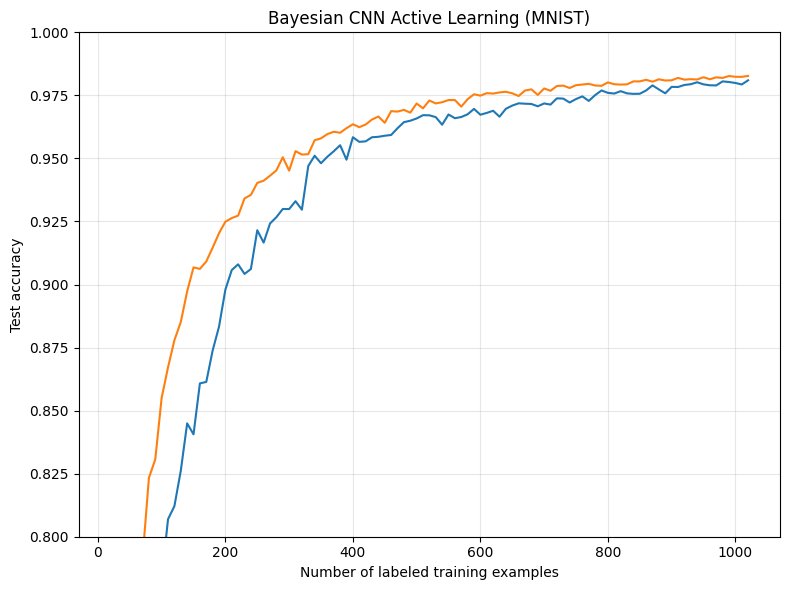

In [15]:
#@title Plot Any Graphs
file_names = ["outputs/replicate5-1/history_BCNN_BALD_AVG_STATS.json", "outputs/cnn_ssl/history_CNN_SSL_BALD_AVG_STATS.json"]
history_list = []
for file_name in file_names:
    with open(file_name, 'r') as f:
        history = json.load(f)
        history_list.append(history)

plot_active_learning_curves(history_list, ylim=(0.8, 1.0))